In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import xgboost as xgb
import bisect
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest

pd.set_option('display.max_columns', None)

train = pd.read_csv(r'C:\Users\dlwks\OneDrive\바탕 화면\VSCode\HD_AI_Challenge\train.csv').drop(columns=['SAMPLE_ID', 'U_WIND', 'V_WIND', 'AIR_TEMPERATURE', 'BN'])
test = pd.read_csv(r'C:\Users\dlwks\OneDrive\바탕 화면\VSCode\HD_AI_Challenge\test.csv').drop(columns=['SAMPLE_ID', 'U_WIND', 'V_WIND', 'AIR_TEMPERATURE', 'BN'])

| 항목                 | 설명                                                             |
|---------------------|------------------------------------------------------------------|
| ARI_CO              | 도착항의 소속국가(도착항 앞 2글자)                                |
| ARI_PO              | 도착항의 항구명(도착항 뒤 글자)                                  |
| SHIP_TYPE_CATEGORY  | 선종 통합 바탕으로 5대 선종으로 분류                              |
| DIST                | 정박지(ber_port)와 접안지 사이의 거리                              |
| ATA                 | anc_port에 도착한 시점의 utc. 실제 정박 시각(Actual Time of Arrival) |
| ID                  | 선박식별 일련번호                                                  |
| BREADTH             | 선박의 폭                                                         |
| BUILT               | 선박의 연령                                                       |
| DEADWEIGHT          | 선박의 재화중량톤수                                               |
| DEPTH               | 선박의 깊이                                                       |
| DRAUGHT             | 흘수 높이                                                        |
| GT                  | 용적톤수(Gross Tonnage)값                                        |
| LENGTH              | 선박의 길이                                                       |
| SHIPMANAGER         | 선박 소유주                                                       |
| FLAG                | 선박의 국적                                                       |
| U_WIND              | 풍향 u벡터                                                        |
| V_WIND              | 풍향 v벡터                                                        |
| AIR_TEMPERATURE     | 기온                                                              |
| BN                  | 보퍼트 풍력 계급                                                  |
| ATA_LT              | anc_port에 도착한 시점의 현지 정박 시각(Local Time of Arrival)(단위 : H) |
| DUBAI               | 해당일의 두바이유 값                                              |
| BRENT               | 해당일의 브렌트유 값                                              |
| WTI                 | 해당일의 WTI 값                                                  |
| BDI_ADJ             | 조정된 벌크운임지수                                                |
| PORT_SIZE           | 접안지 폴리곤 영역의 크기                                         |
| CI_HOUR  | 대기시간 |           |


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 391939 entries, 0 to 391938
Data columns (total 18 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   ARI_CO              391939 non-null  object 
 1   ARI_PO              391939 non-null  object 
 2   SHIP_TYPE_CATEGORY  391939 non-null  object 
 3   DIST                391939 non-null  float64
 4   ATA                 391939 non-null  object 
 5   ID                  391939 non-null  object 
 6   BREADTH             391938 non-null  float64
 7   BUILT               391939 non-null  int64  
 8   DEADWEIGHT          391939 non-null  int64  
 9   DEPTH               391938 non-null  float64
 10  DRAUGHT             391938 non-null  float64
 11  GT                  391939 non-null  int64  
 12  LENGTH              391938 non-null  float64
 13  SHIPMANAGER         391939 non-null  object 
 14  FLAG                391939 non-null  object 
 15  ATA_LT              391939 non-nul

In [ ]:
train.describe()

DIST       BREADTH          BUILT     DEADWEIGHT  \
count  391939.000000  391938.00000  391939.000000  391939.000000   
mean       19.328187      30.55001      14.747989   63577.506780   
std        30.930059      10.95707       7.043988   63515.531024   
min         0.000000      10.00000       0.000000     100.000000   
25%         0.000000      20.00000      10.000000   14300.000000   
50%         6.929678      30.00000      13.000000   47400.000000   
75%        25.692827      40.00000      18.000000   81500.000000   
max       199.980651      60.00000      80.000000  404000.000000   

               DEPTH        DRAUGHT             GT         LENGTH  \
count  391938.000000  391938.000000  391939.000000  391938.000000   
mean       16.476177      11.088106   41348.968666     205.121320   
std         6.045930       4.599298   39304.543664      75.873891   
min         0.000000       0.000000     150.000000      20.000000   
25%        10.000000      10.000000   10000.000000     150.000000   
50%        20.000000      10.000000   30700.000000     190.000000   
75%        20.000000      10.000000   52100.000000     260.000000   
max        30.000000      20.000000  237000.000000     400.000000   

              ATA_LT      PORT_SIZE        CI_HOUR  
count  391939.000000  391939.000000  391939.000000  
mean       11.841580       0.000876      61.940835  
std         6.644114       0.000838     170.809558  
min         0.000000       0.000005       0.000000  
25%         7.000000       0.000142       0.000000  
50%        12.000000       0.000552       7.944444  
75%        17.000000       0.001614      49.176111  
max        23.000000       0.002615    2159.130556

In [ ]:
test.describe()

DIST        BREADTH          BUILT     DEADWEIGHT  \
count  220491.000000  220491.000000  220491.000000  220491.000000   
mean       19.302172      30.529409      14.749944   63478.206321   
std        30.902778      10.940594       7.060537   63438.635816   
min         0.000000      10.000000       0.000000     100.000000   
25%         0.000000      20.000000      10.000000   14100.000000   
50%         6.898127      30.000000      13.000000   47200.000000   
75%        25.632636      40.000000      18.000000   81500.000000   
max       199.997495      70.000000      71.000000  404000.000000   

               DEPTH        DRAUGHT             GT         LENGTH  \
count  220491.000000  220491.000000  220491.000000  220491.000000   
mean       16.463983      11.082675   41253.040759     204.943512   
std         6.040931       4.589031   39185.762241      75.812259   
min         0.000000       0.000000     150.000000      20.000000   
25%        10.000000      10.000000   10000.000000     150.000000   
50%        20.000000      10.000000   30600.000000     190.000000   
75%        20.000000      10.000000   51900.000000     260.000000   
max        30.000000      20.000000  237000.000000     400.000000   

              ATA_LT      PORT_SIZE  
count  220491.000000  220491.000000  
mean       11.836751       0.000877  
std         6.646983       0.000839  
min         0.000000       0.000005  
25%         7.000000       0.000142  
50%        12.000000       0.000552  
75%        17.000000       0.001614  
max        23.000000       0.002615

In [ ]:
# datetime 컬럼 처리
train['ATA'] = pd.to_datetime(train['ATA'])
test['ATA'] = pd.to_datetime(test['ATA'])

# datetime을 여러 파생 변수로 변환
for df in [train, test]:
    df['year'] = df['ATA'].dt.year
    df['month'] = df['ATA'].dt.month
    # df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    # df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    df['day'] = df['ATA'].dt.day
    df['hour'] = df['ATA'].dt.hour
    df['minute'] = df['ATA'].dt.minute
    df['weekday'] = df['ATA'].dt.weekday

train.drop(columns=['ATA'], inplace=True)
test.drop(columns=['ATA'], inplace=True)
# train.drop(columns=['ATA', 'month'], inplace=True)
# test.drop(columns=['ATA', 'month'], inplace=True)

In [ ]:
# selected_id = train['ARI_PO'].unique()[0]
# selected_rows = train[train['ARI_PO'] == selected_id]

# sorted_train = selected_rows.sort_values(by=['year', 'month', 'day', 'hour', 'minute'])

# a = sorted_train.drop(['BREADTH', 'BUILT', 'DEADWEIGHT', 'DEPTH', 'DRAUGHT', 'GT', 'LENGTH'], axis=1)
# a.head(50)

# EDA 시각화

In [ ]:
len(train[(train['DIST'] == 0) & (train['CI_HOUR'] == 0)]), len(train[(train['DIST'] == 0) & (train['CI_HOUR'] != 0)]), len(train[(train['DIST'] != 0) & (train['CI_HOUR'] == 0)])

(157265, 28, 0)

In [ ]:
# num = train.select_dtypes(exclude='object')
# sns.pairplot(data=num)

Output hidden; open in https://colab.research.google.com to view.

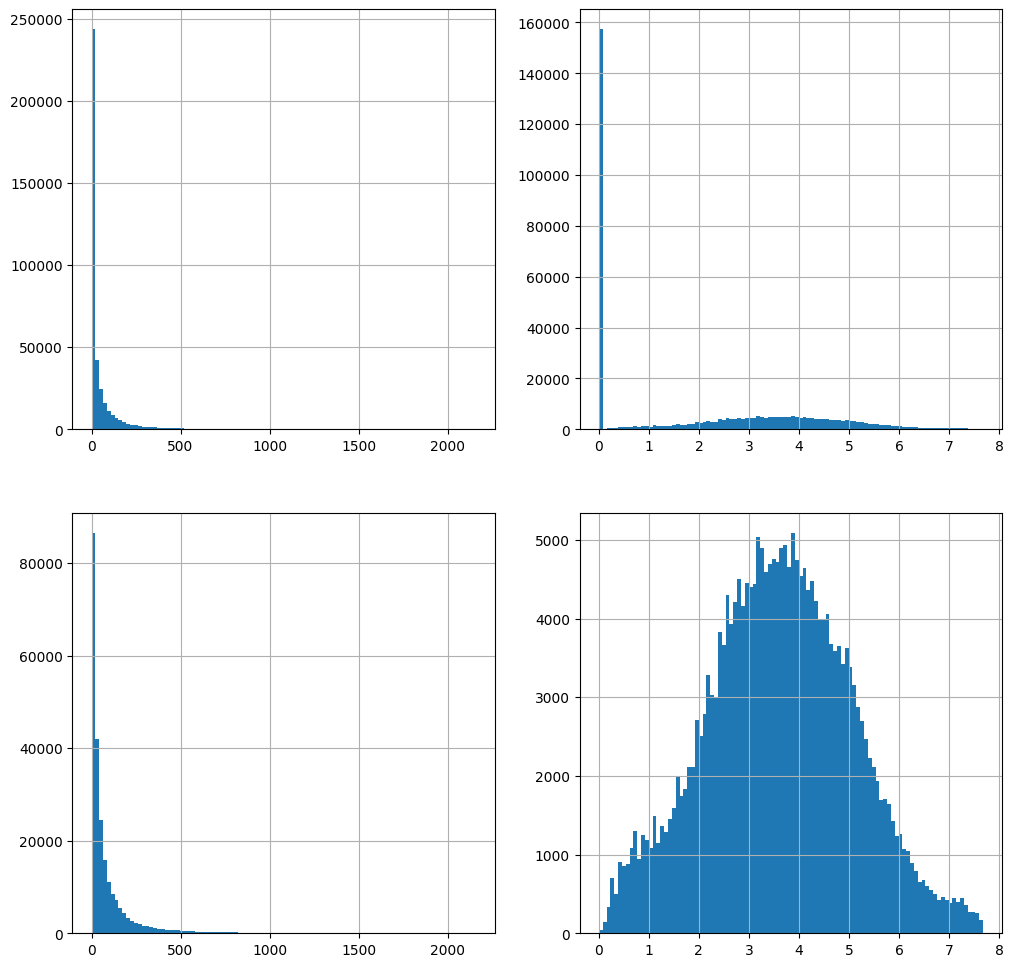

In [ ]:
train_ = train[(train['DIST'] != 0)].reset_index(drop=True)

plt.figure(figsize=(12, 12))

plt.subplot(2, 2, 1)
train['CI_HOUR'].hist(bins=100)

plt.subplot(2, 2, 2)
np.log1p(train['CI_HOUR']).hist(bins=100)

plt.subplot(2, 2, 3)
train_['CI_HOUR'].hist(bins=100)

plt.subplot(2, 2, 4)
np.log1p(train_['CI_HOUR']).hist(bins=100)

train_['CI_trans'] = np.log1p(train_['CI_HOUR'])

In [ ]:
# datetime 형식의 새로운 열 생성
train_['datetime'] = pd.to_datetime(train_[['year', 'month', 'day']])

# 'ID' 및 'datetime' 열을 기준으로 데이터 정렬
train_ = train_.sort_values(by=['ID', 'datetime'])

# 각 ID별로 그룹을 나눈 후, 이전 행의 날짜와의 차이 계산
train_['days_diff'] = train_.groupby('ID')['datetime'].diff().dt.days
train_['days_diff'].fillna(0, inplace=True)
train_ = train_.drop(columns= 'datetime')


# 그룹화를 진행하고 선박 수를 계산
grouped_ships = train_.groupby(['year', 'month', 'ARI_PO']).size().reset_index(name='ship_counts_per_month')
train_ = pd.merge(train_, grouped_ships, on=['year', 'month', 'ARI_PO'], how='left')
test = pd.merge(test, grouped_ships, on=['year', 'month', 'ARI_PO'], how='left')


grouped_ships = train_.groupby(['year', 'month', 'day', 'ARI_PO']).size().reset_index(name='ship_counts_per_day')
train_ = pd.merge(train_, grouped_ships, on=['year', 'month', 'day', 'ARI_PO'], how='left')
test = pd.merge(test, grouped_ships, on=['year', 'month', 'day', 'ARI_PO'], how='left')

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


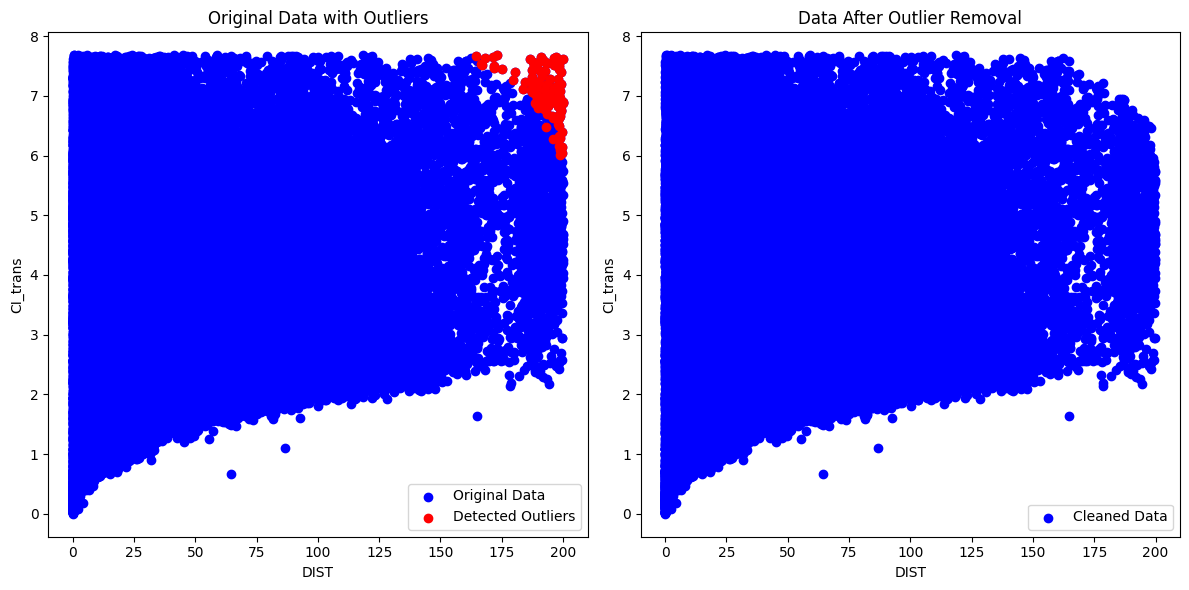

In [ ]:
iso_forest = IsolationForest(contamination=0.0005)
labels = iso_forest.fit_predict(train_[['DIST', 'CI_trans']])

noise_idx = np.where(labels == -1)[0]

X_cleaned = train_.drop(noise_idx)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(train_['DIST'], train_['CI_trans'], c='blue', label='Original Data')
plt.scatter(train_.iloc[noise_idx]['DIST'], train_.iloc[noise_idx]['CI_trans'], c='red', label='Detected Outliers')
plt.title("Original Data with Outliers")
plt.xlabel("DIST")
plt.ylabel("CI_trans")
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(X_cleaned['DIST'], X_cleaned['CI_trans'], c='blue', label='Cleaned Data')
plt.title("Data After Outlier Removal")
plt.xlabel("DIST")
plt.ylabel("CI_trans")
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
condition = ((train_['DIST'] > 50) & (train_['CI_trans'] < 1.1)) | ((train_['DIST'] > 150) & (train_['CI_trans'] < 2)) | ((train_['DIST'] > 175) & (train_['CI_trans'] < 2.8))
train_ = train_.loc[~condition].reset_index()

In [ ]:
# datetime 형식의 새로운 열 생성
train_['datetime'] = pd.to_datetime(train_[['year', 'month', 'day']])

# 'ID' 및 'datetime' 열을 기준으로 데이터 정렬
train_ = train_.sort_values(by=['ID', 'datetime'])

# 각 ID별로 그룹을 나눈 후, 이전 행의 날짜와의 차이 계산
train_['days_diff'] = train_.groupby('ID')['datetime'].diff().dt.days
train_['days_diff'].fillna(0, inplace=True)
train_ = train_.drop(columns= 'datetime')

In [ ]:
train_.head(50)

index ARI_CO ARI_PO SHIP_TYPE_CATEGORY        DIST       ID  BREADTH  \
145700  145733     JP   ZAG4              Cargo  137.539160  A111164     10.0   
89524    89546     JP   HYG5              Cargo   10.424175  A111164     10.0   
155404  155440     JP   ZAG4              Cargo    7.881777  A111164     10.0   
177691  177732     JP   HYG5              Cargo   11.803713  A111164     10.0   
48485    48502     JP   HYG5              Cargo   12.421196  A111164     10.0   
36757    36771     JP   HYG5              Cargo   13.523114  A111164     10.0   
73515    73536     JP   HYG5              Cargo   10.870219  A111164     10.0   
173658  173699     JP   HYG5              Cargo   11.001536  A111164     10.0   
36350    36364     JP   HYG5              Cargo   15.160929  A111164     10.0   
105221  105249     JP   ZAG4              Cargo    6.906200  A111164     10.0   
172276  172317     JP   HYG5              Cargo   11.293836  A111164     10.0   
53065    53082     JP   HYG5              Cargo   11.571311  A111164     10.0   
222295  222346     JP   HYG5              Cargo   10.326198  A111164     10.0   
164798  164835     JP   HYG5              Cargo   10.434383  A111164     10.0   
215778  215826     JP   HYG5              Cargo   11.015288  A111164     10.0   
85441    85462     JP   HYG5              Cargo   11.228556  A111164     10.0   
118478  118509     JP   HYG5              Cargo   11.857671  A111164     10.0   
23091    23099     JP   HYG5              Cargo   11.263085  A111164     10.0   
193807  193854     JP   HYG5              Cargo   10.648943  A111164     10.0   
140408  140441     JP   HYG5              Cargo   10.657052  A111164     10.0   
63403    63422     JP   ZAG4              Cargo    8.419660  A111164     10.0   
193602  193649     JP   ZAG4              Cargo    8.970210  A111164     10.0   
233880  233934     JP   HYG5              Cargo   11.909746  A111164     10.0   
11939    11945     JP   ZAG4              Cargo    8.414932  A111164     10.0   
225055  225106     JP   HYG5              Cargo   11.085542  A111164     10.0   
103458  103484     JP   HYG5              Cargo   11.528078  A111164     10.0   
129371  129402     JP   ZAG4              Cargo    9.266831  A111164     10.0   
144591  144624     JP   HYG5              Cargo   10.941209  A111164     10.0   
119729  119760     JP   ZAG4              Cargo    6.208455  A111164     10.0   
4771      4773     JP   ZAG4              Cargo   85.707907  A111164     10.0   
159306  159343     JP   HYG5              Cargo   10.887583  A111164     10.0   
80398    80419     JP   ZAG4              Cargo  137.127258  A111164     10.0   
178761  178803     JP   ZAG4              Cargo    8.306748  A111164     10.0   
122493  122524     JP   ZAG4              Cargo    6.777557  A111164     10.0   
156031  156067     JP   HYG5              Cargo   11.588328  A111164     10.0   
109256  109284     JP   ZAG4              Cargo    6.148023  A111164     10.0   
51353    51370     JP   HYG5              Cargo   10.726914  A111164     10.0   
93083    93105     JP   ZAG4              Cargo   90.198675  A111164     10.0   
25410    25420     JP   ZAG4              Cargo  141.005725  A111164     10.0   
176465  176506     JP   ZAG4              Cargo    6.481653  A111164     10.0   
60815    60834     JP   ZAG4              Cargo  136.822778  A111164     10.0   
103169  103195     JP   ZAG4              Cargo    6.916236  A111164     10.0   
148760  148793     JP   HYG5              Cargo   11.704060  A111164     10.0   
57354    57372     JP   ZAG4              Cargo  141.003016  A111164     10.0   
23202    23210     JP   HYG5              Cargo   10.332852  A111164     10.0   
40090    40107     JP   HYG5              Cargo   10.710273  A111164     10.0   
193767  193814     JP   HYG5              Cargo   11.189877  A111164     10.0   
220155  220204     JP   ZAG4              Cargo    7.833399  A111164     10.0   
208021  208069     JP   HYG5            

<Axes: xlabel='ARI_PO', ylabel='CI_trans'>

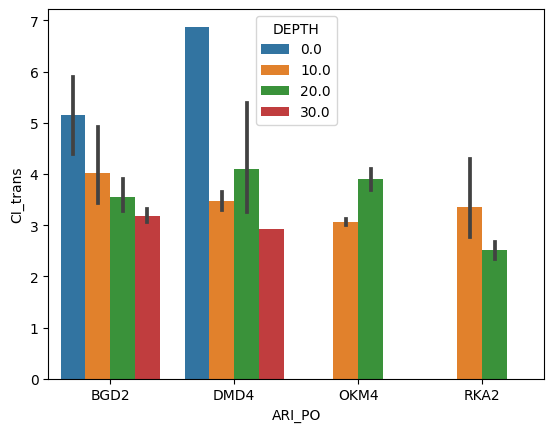

In [ ]:
a = train_[train_['ARI_CO'] == 'KR']
b = a.groupby(['ARI_PO', 'SHIP_TYPE_CATEGORY', 'DEPTH'])['CI_trans'].mean().reset_index()

sns.barplot(x='ARI_PO', y='CI_trans', hue='DEPTH', data=b)

ARI_PO SHIP_TYPE_CATEGORY  DEPTH     CI_HOUR
0    BGD2               Bulk   10.0   93.485385
1    BGD2               Bulk   20.0  108.734439
2    BGD2               Bulk   30.0   45.807267
3    BGD2              Cargo    0.0   80.083056
4    BGD2              Cargo   10.0   98.243055
5    BGD2              Cargo   20.0   53.123866
6    BGD2          Container   10.0  106.654664
7    BGD2          Container   20.0   69.109675
8    BGD2          Container   30.0   41.806639
9    BGD2             Tanker    0.0  397.620185
10   BGD2             Tanker   10.0  407.064907
11   DMD4               Bulk   10.0   61.578829
12   DMD4               Bulk   20.0   66.987761
13   DMD4               Bulk   30.0   56.261991
14   DMD4              Cargo   10.0   78.732947
15   DMD4              Cargo   20.0   27.951288
16   DMD4             Tanker    0.0  969.625000
17   DMD4             Tanker   10.0   87.693056
18   DMD4             Tanker   20.0  216.778750
19   OKM4               Bulk   10.0   41.874846
20   OKM4               Bulk   20.0  112.988990
21   OKM4              Cargo   10.0   68.431190
22   OKM4              Cargo   20.0   39.204444
23   RKA2               Bulk   20.0   15.646389
24   RKA2              Cargo   10.0  178.795139
25   RKA2          Container   10.0   36.183981
26   RKA2          Container   20.0    9.461667
27   RKA2             Tanker   10.0  158.851270

In [ ]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

# # ARI_PO를 수치형으로 인코딩
# ari_po_mapping = {value: idx for idx, value in enumerate(train_['ARI_PO'].unique())}
# train_['ARI_PO_encoded'] = train_['ARI_PO'].map(ari_po_mapping)
# test['ARI_PO_encoded'] = test['ARI_PO'].map(ari_po_mapping)

def compute_smoothed_means(df, group_cols, target_col, m, global_mean=None):
    if global_mean is None:
        global_mean = df[target_col].mean()

    grouped_mean = df.groupby(group_cols)[target_col].mean()
    grouped_count = df.groupby(group_cols)[target_col].count()

    # 평활화된 평균 계산
    smoothed_means = (grouped_mean * grouped_count + global_mean * m) / (grouped_count + m)
    return smoothed_means

# 1. train_ 데이터에서 smoothed mean 계산
grouped_mean_po = compute_smoothed_means(train_, ['ARI_PO', 'DIST'], 'CI_trans', m=30)
train_['n4'] = train_.set_index(['ARI_PO','DIST']).index.map(grouped_mean_po)
test['n4'] = test.set_index(['ARI_PO','DIST']).index.map(grouped_mean_po)

# grouped_mean_po = compute_smoothed_means(train_, ['DWT_class', 'n4'], 'CI_trans', m=30)
# train_['n5'] = train_.set_index(['DWT_class', 'n4']).index.map(grouped_mean_po)
# test['n5'] = test.set_index(['DWT_class', 'n4']).index.map(grouped_mean_po)


# 2. KNN 모델 학습
# knn = NearestNeighbors(n_neighbors=1).fit(train_[['ARI_PO_encoded', 'DIST']])

# # test 데이터의 ARI_PO_encoded와 DIST 값을 사용하여 가장 가까운 train_ 데이터의 값을 찾음
# test_dists, test_indices = knn.kneighbors(test[['ARI_PO_encoded', 'DIST']])

# # 해당 인덱스들로부터 train_ 데이터의 ARI_PO_encoded와 DIST 값을 가져와서 test에 저장
# test['nearest_ari_po_encoded'] = train_['ARI_PO_encoded'].iloc[test_indices.squeeze()].values
# test['nearest_dist'] = train_['DIST'].iloc[test_indices.squeeze()].values

# # 이제 근접한 ARI_PO_encoded와 DIST 값을 조합하여 test 데이터에 n4 값을 매핑
# test['n4'] = test.set_index(['nearest_ari_po_encoded', 'nearest_dist']).index.map(grouped_mean_po)


In [ ]:
# Index(['ARI_CO', 'ARI_PO', 'SHIP_TYPE_CATEGORY', 'DIST', 'ID', 'BREADTH',
#        'BUILT', 'DEADWEIGHT', 'DEPTH', 'DRAUGHT', 'GT', 'LENGTH',
#        'SHIPMANAGER', 'FLAG', 'U_WIND', 'V_WIND', 'AIR_TEMPERATURE', 'BN',
#        'ATA_LT', 'PORT_SIZE', 'CI_HOUR', 'year', 'month', 'day', 'hour',
#        'minute', 'weekday', 'CI_trans', 'n4', 'DWT_class'],
#       dtype='object')

In [ ]:
test['n4'].isnull().sum()

131716

<Axes: xlabel='n4', ylabel='CI_trans'>

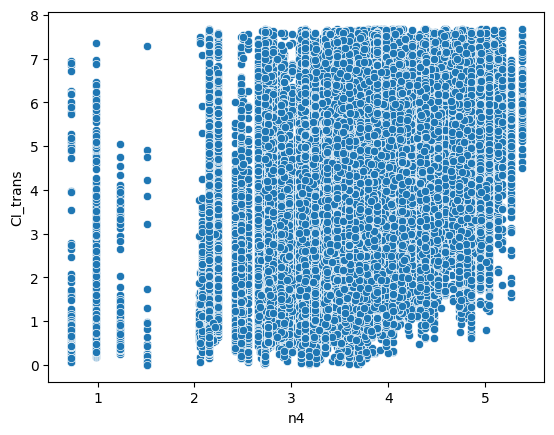

In [ ]:
# train_['n4'].hist(bins=1000)
# test['n4'].hist(bins=1000)

sns.scatterplot(x='n4', y='CI_trans', data=train_)

In [ ]:
grouped_mean = train_.groupby(['ARI_PO', 'DIST'])['CI_trans'].mean()
grouped_mean

ARI_PO  DIST     
AIB7    0.105960     4.509931
        0.106900     3.310523
        0.203439     2.030375
        0.232968     0.115311
        0.506428     5.847982
                       ...   
ZME5    43.797610    2.496025
        44.644464    3.218576
        44.702847    4.377893
        54.013180    4.594247
        54.329953    5.586961
Name: CI_trans, Length: 234300, dtype: float64

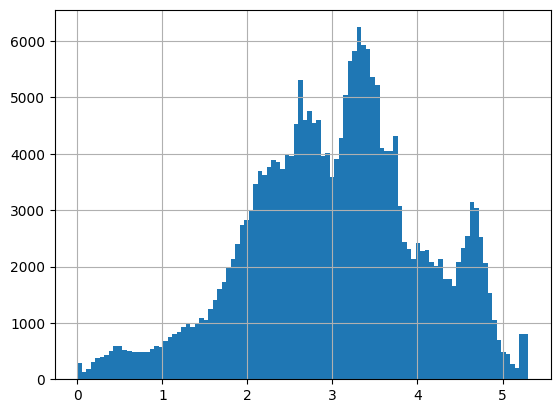

In [ ]:
np.log1p(train_['DIST']).hist(bins=100)
a = np.log1p(train_['DIST'])

In [ ]:
train_['DIST'] = np.round(a)

In [ ]:
train_ = train_[(train_['BN'] != 0) & (train_['BN'].notna())]
train_

ARI_CO ARI_PO SHIP_TYPE_CATEGORY       DIST       ID  BREADTH  BUILT  \
1          SG   GIW5          Container  27.037650  A872328     50.0     10   
2          AU   WHH4               Bulk  49.953585  S731836     40.0      7   
5          CN   UVK6               Bulk  18.022495  U334123     30.0     11   
8          CN   TDA5               Bulk  21.887307  R763644     40.0      9   
11         AU   NQO4              Cargo  29.624768  Q418441     30.0     27   
...       ...    ...                ...        ...      ...      ...    ...   
234665     AU   WHH4               Bulk  55.601755  D468281     50.0      8   
234666     SG   GIW5          Container   7.304235  Q875425     40.0      9   
234670     CN   NCU8               Bulk   9.647703  H321245     30.0     26   
234671     SG   GIW5               Bulk   5.884603  K635567     10.0     12   
234672     US   QGN3               Bulk  70.660241  J284147     30.0      8   

        DEADWEIGHT  DEPTH  DRAUGHT      GT  LENGTH SHIPMANAGER  \
1           116000   20.0     10.0   96600   300.0      GUCE76   
2           183000   20.0     20.0   94100   290.0      HZUO14   
5            35000   20.0     10.0   22500   180.0      KLJL33   
8            70400   20.0     10.0   54600   220.0      HULF38   
11           55800   20.0     10.0   36000   200.0      GXKR25   
...            ...    ...      ...     ...     ...         ...   
234665      210000   20.0     20.0  107000   300.0      UBYU81   
234666       51700   20.0     10.0   41700   230.0      PIIS74   
234670       69000   20.0     10.0   35900   220.0      PPMJ71   
234671        3160   10.0     10.0    1600    80.0      JLTM64   
234672       60300   20.0     10.0   34800   200.0      YERJ68   

                    FLAG  U_WIND  V_WIND  AIR_TEMPERATURE        BN  ATA_LT  \
1                Liberia   -0.33   -3.28             25.6  2.495953      15   
2                  Japan    6.10   -2.84             28.1  4.016217       5   
5             Montenegro   -2.16    1.50             25.6  2.146870      10   
8       Hong Kong, China   -4.88    1.55             21.9  3.347518       5   
11               Bahamas   -1.25    1.09             20.3  1.578841       9   
...                  ...     ...     ...              ...       ...     ...   
234665           Liberia    6.97    1.47             24.9  4.171745       2   
234666         Singapore   -0.98   -3.79             26.1  2.798925       6   
234670            Panama    3.64    3.44             21.4  3.298553      21   
234671           Vietnam   -0.66    0.97             27.3  1.253491       8   
234672         Singapore   -3.44    7.99             21.1  4.766257      18   

        PORT_SIZE      CI_HOUR  year  month  day  hour  minute  weekday  \
1        0.002615   253.554444  2020      1   26     7      51        6   
2        0.000103    68.391389  2021      3    5    18      36        4   
5        0.000520     2.721944  2021      9   23     2      48        3   
8        0.000455     7.374722  2021      5   12    21      35        2   
11       0.000110    18.007222  2020     11   17    22      41        1   
...           ...          ...   ...    ...  ...   ...     ...      ...   
234665   0.000103    55.701667  2021     10   26    15      41        1   
234666   0.002615    23.914444  2019     12    3    22      51        1   
234670   0.000939  1095.597222  2020      3    2    13      37        0   
234671   0.002615   144.061389  2019     10   16     0      36        2   
234672   0.000155    41.482222  2021      3   23    22      35        1   

        CI_trans  
1       5.539515  
2       4.239763  
5       1.314246  
8       2.125218  
11      2.944819  
...          ...  
234665  4.037804  
234666  3.215448  
234670  6.999967  
234671  4.977157  
234672  3.749086  

[134240 rows x 28 columns]

<ipython-input-100-6bc7cc9c2536>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(train_.corr(), annot=True, fmt='.2f')


<Axes: >

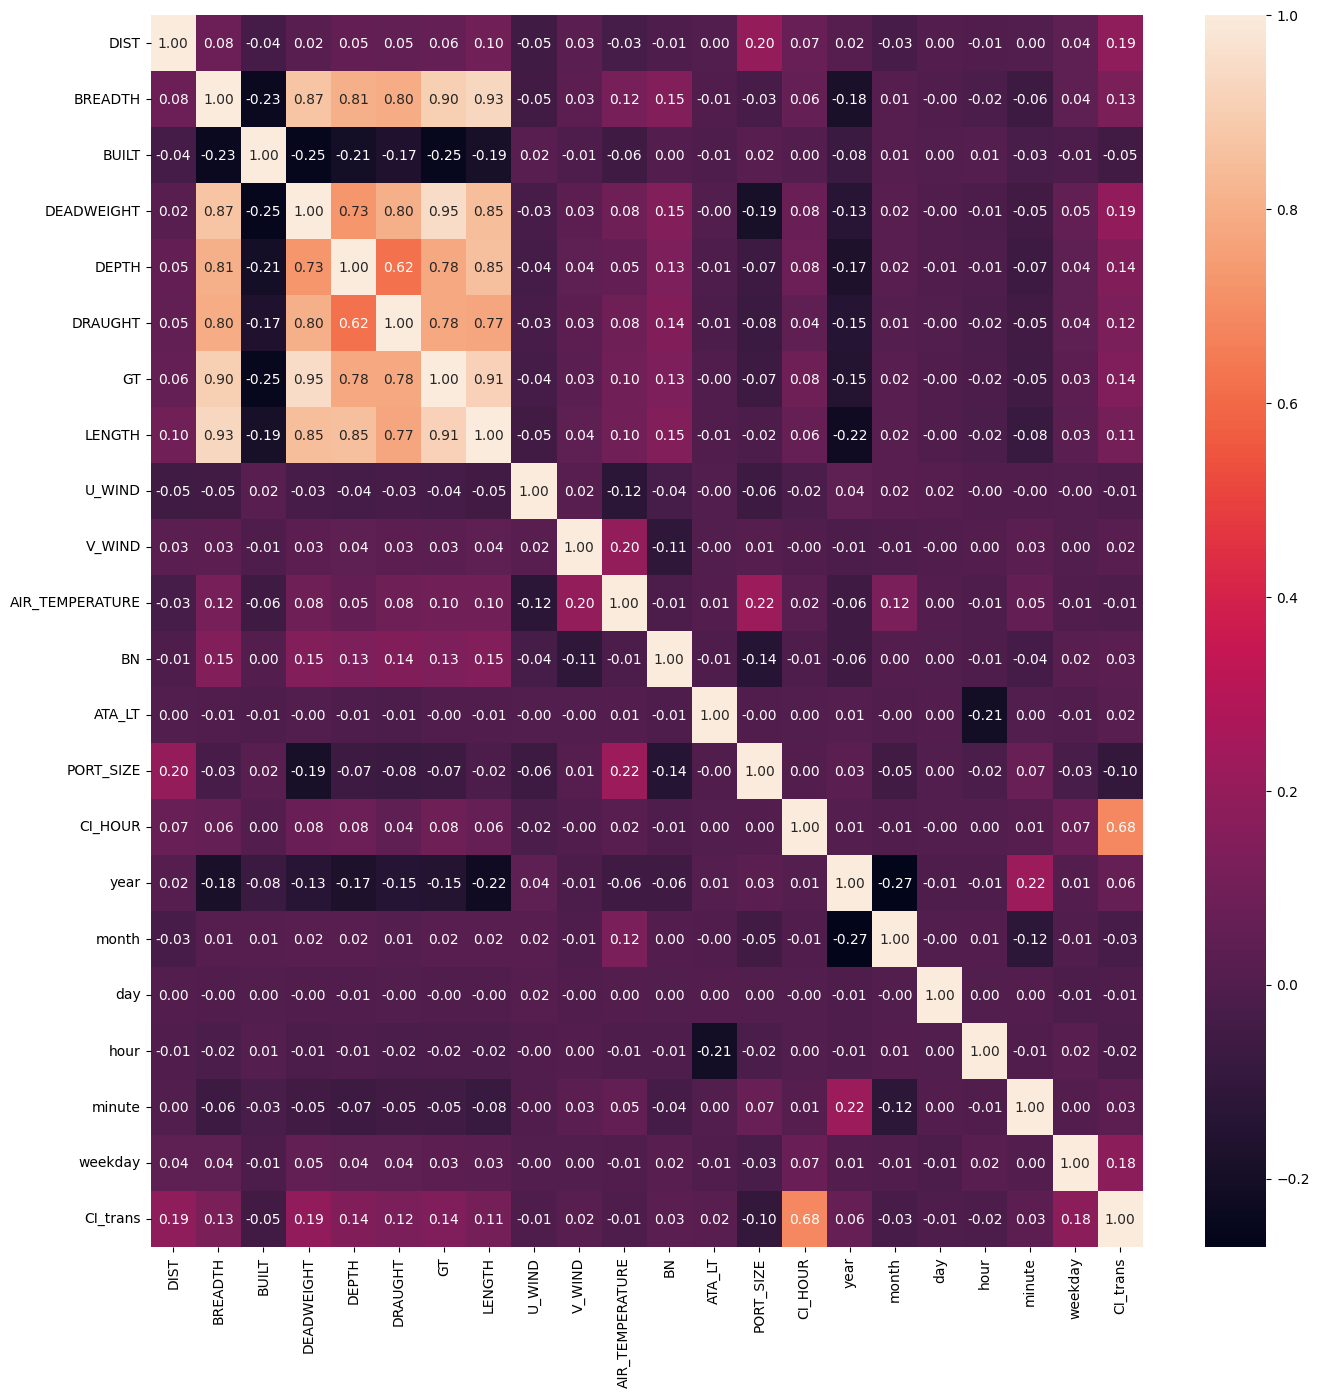

In [ ]:
plt.figure(figsize=(16, 16))
sns.heatmap(train_.corr(), annot=True, fmt='.2f')

## SHIP_TYPE_CATEGORY의 시각화


### 배의 카테고리별 대기시간

<Axes: xlabel='SHIP_TYPE_CATEGORY', ylabel='CI_HOUR'>

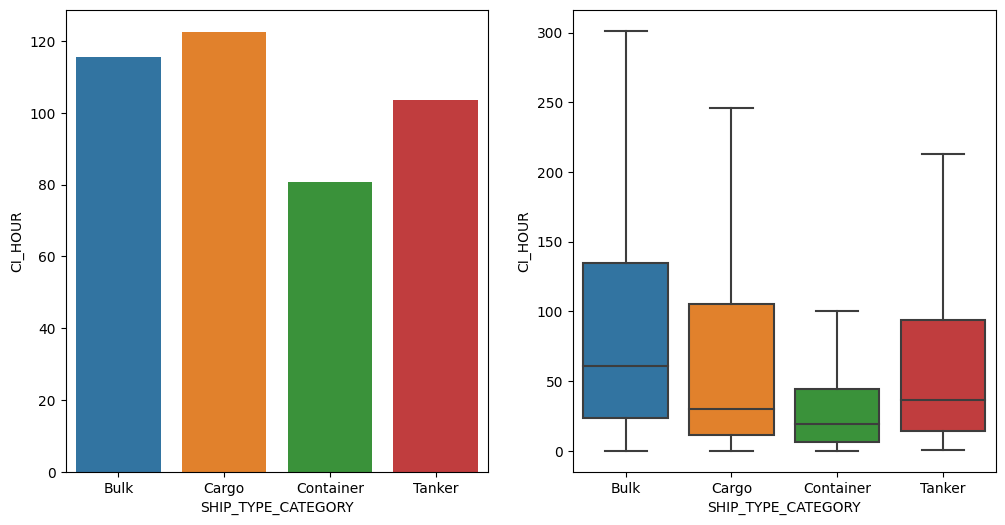

In [ ]:
train_shipcat = train_.groupby(['SHIP_TYPE_CATEGORY'])['CI_HOUR'].mean().reset_index()

category_order = train_shipcat['SHIP_TYPE_CATEGORY'].tolist()

plt.figure(figsize=(12,6))

plt.subplot(1, 2, 1)
sns.barplot(x='SHIP_TYPE_CATEGORY', y='CI_HOUR', data=train_shipcat, order=category_order)

plt.subplot(1, 2, 2)
sns.boxplot(x='SHIP_TYPE_CATEGORY', y='CI_HOUR', data=train_, showfliers=False, order=category_order)

### 배의 카테고리별 재화중량톤수

<Axes: xlabel='SHIP_TYPE_CATEGORY', ylabel='DEADWEIGHT'>

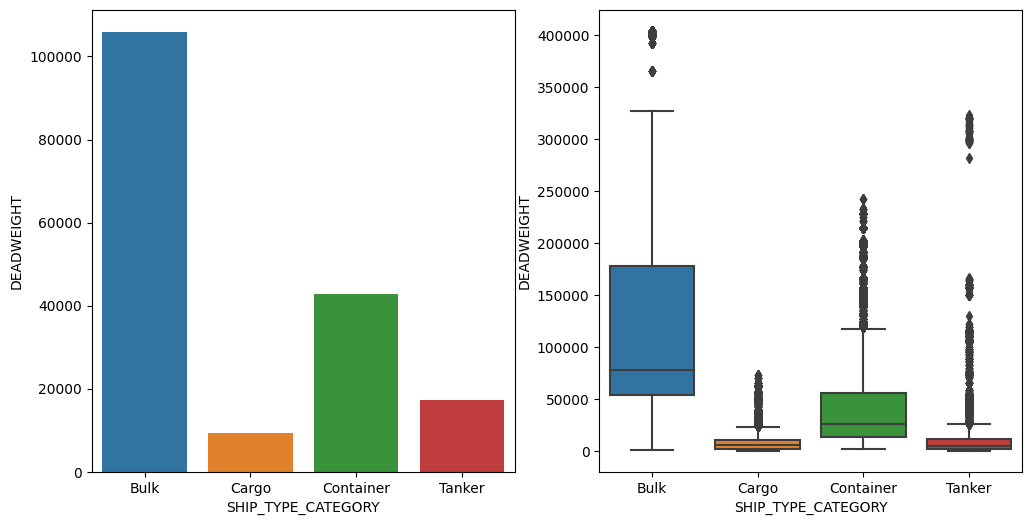

In [ ]:
train_shipcat = train_.groupby(['SHIP_TYPE_CATEGORY'])['DEADWEIGHT'].mean().reset_index()

category_order = train_shipcat['SHIP_TYPE_CATEGORY'].tolist()

plt.figure(figsize=(12,6))

plt.subplot(1, 2, 1)
sns.barplot(x='SHIP_TYPE_CATEGORY', y='DEADWEIGHT', data=train_shipcat, order=category_order)

plt.subplot(1, 2, 2)
sns.boxplot(x='SHIP_TYPE_CATEGORY', y='DEADWEIGHT', data=train_, showfliers=True, order=category_order)

In [ ]:
# https://www.cello-square.com/kr-ko/blog/view-29.do

def classify_gt(value):
    if value < 40000:
        return 0
    elif value < 55000:
        return 1
    elif value < 60000:
        return 2
    elif value < 100000:
        return 3
    elif value < 180000:
        return 4
    elif value < 200000:
        return 5
    else:
        return 6

# 데이터프레임 예시: train_
train_['DWT_class'] = train_['DEADWEIGHT'].apply(classify_gt)
test['DWT_class'] = test['DEADWEIGHT'].apply(classify_gt)
train_

ARI_CO ARI_PO SHIP_TYPE_CATEGORY        DIST       ID  BREADTH  BUILT  \
0          SG   GIW5          Container   30.881018  Z618338     30.0     24   
1          SG   GIW5          Container   27.037650  A872328     50.0     10   
2          AU   WHH4               Bulk   49.953585  S731836     40.0      7   
3          ID   REJ1          Container   42.276281  A735263     20.0     30   
4          CN   NGG6          Container  101.521598  S458225     50.0      7   
...       ...    ...                ...         ...      ...      ...    ...   
234669     CN   WAF5               Bulk   21.866691  V427658     40.0     13   
234670     CN   NCU8               Bulk    9.647703  H321245     30.0     26   
234671     SG   GIW5               Bulk    5.884603  K635567     10.0     12   
234672     US   QGN3               Bulk   70.660241  J284147     30.0      8   
234673     TW   JWI3          Container    9.448179  J644215     30.0     29   

        DEADWEIGHT  DEPTH  DRAUGHT      GT  LENGTH SHIPMANAGER  \
0            24300   10.0     10.0   16700   180.0      CQSB78   
1           116000   20.0     10.0   96600   300.0      GUCE76   
2           183000   20.0     20.0   94100   290.0      HZUO14   
3             6800   10.0     10.0    4810   110.0      HCOS27   
4           124000   30.0     20.0  111000   320.0      YLMR26   
...            ...    ...      ...     ...     ...         ...   
234669      169000   20.0     20.0   89400   290.0      TNIW71   
234670       69000   20.0     10.0   35900   220.0      PPMJ71   
234671        3160   10.0     10.0    1600    80.0      JLTM64   
234672       60300   20.0     10.0   34800   200.0      YERJ68   
234673       23800   10.0     10.0   16900   170.0      HCZK58   

                    FLAG  U_WIND  V_WIND  AIR_TEMPERATURE        BN  ATA_LT  \
0                 Panama     NaN     NaN              NaN       NaN       5   
1                Liberia   -0.33   -3.28             25.6  2.495953      15   
2                  Japan    6.10   -2.84             28.1  4.016217       5   
3              Indonesia     NaN     NaN              NaN       NaN      10   
4         United Kingdom     NaN     NaN              NaN       NaN       3   
...                  ...     ...     ...              ...       ...     ...   
234669  Marshall Islands     NaN     NaN              NaN       NaN      23   
234670            Panama    3.64    3.44             21.4  3.298553      21   
234671           Vietnam   -0.66    0.97             27.3  1.253491       8   
234672         Singapore   -3.44    7.99             21.1  4.766257      18   
234673           Comoros     NaN     NaN              NaN       NaN      15   

        PORT_SIZE      CI_HOUR  year  month  day  hour  minute  weekday  \
0        0.002615     3.450000  2018     12   17    21      29        0   
1        0.002615   253.554444  2020      1   26     7      51        6   
2        0.000103    68.391389  2021      3    5    18      36        4   
3        0.000041    31.700556  2016     12   11     3       0        6   
4        0.001743    58.193056  2018     11   30    19      29        4   
...           ...          ...   ...    ...  ...   ...     ...      ...   
234669   0.000618    89.884167  2017      6    1    15      27        3   
234670   0.000939  1095.597222  2020      3    2    13      37        0   
234671   0.002615   144.061389  2019     10   16     0      36        2   
234672   0.000155    41.482222  2021      3   23    22      35        1   
234673   0.000990     7.485278  2015      1    8     7      15        3   

        CI_trans        n4  DWT_class  
0       1.492904  3.272245          0  
1       5.539515  3.272245          4  
2       4.239763  4.213478          5  
3       3.487392  3.334644          0  
4       4.080804  3.176100          4  
...          ...       ...        ...  
234669  4.509586  3.478492          4  
234670  6.999967  3.892423          3  
234671  4.977157  3.808097          0  
234

In [ ]:
columns_to_convert = ['DWT_class']
for col in columns_to_convert:
    train_[col] = train_[col].astype('object')
    test[col] = test[col].astype('object')

print(train_.dtypes)

ARI_CO                 object
ARI_PO                 object
SHIP_TYPE_CATEGORY     object
DIST                  float64
ID                     object
BREADTH               float64
BUILT                   int64
DEADWEIGHT              int64
DEPTH                 float64
DRAUGHT               float64
GT                      int64
LENGTH                float64
SHIPMANAGER            object
FLAG                   object
U_WIND                float64
V_WIND                float64
AIR_TEMPERATURE       float64
BN                    float64
ATA_LT                  int64
PORT_SIZE             float64
CI_HOUR               float64
year                    int64
month                   int64
day                     int64
hour                    int64
minute                  int64
weekday                 int64
CI_trans              float64
n4                    float64
DWT_class              object
dtype: object


<Axes: xlabel='SHIP_TYPE_CATEGORY', ylabel='CI_HOUR'>

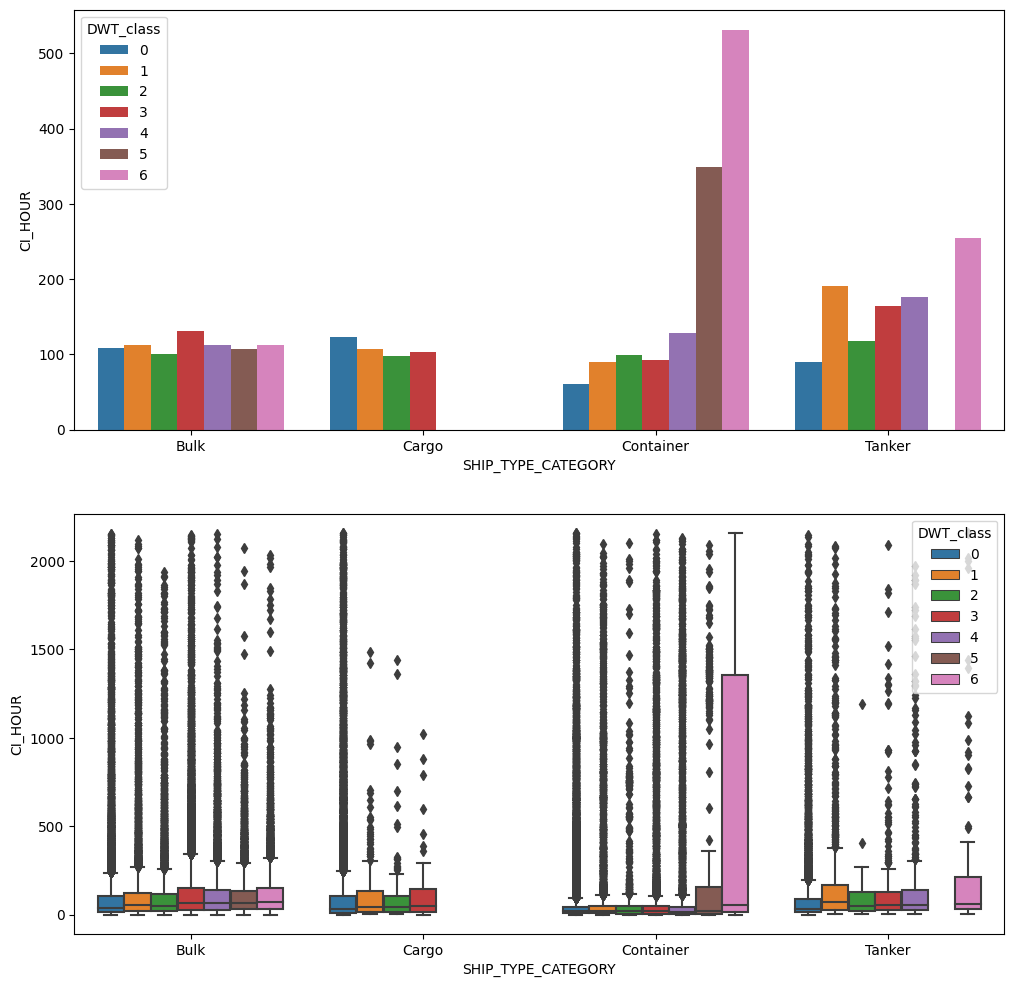

In [ ]:
train_shipcat = train_.groupby(['SHIP_TYPE_CATEGORY', 'DWT_class'])['CI_HOUR'].mean().reset_index()

category_order = train_shipcat['SHIP_TYPE_CATEGORY'].unique().tolist()

plt.figure(figsize=(12,12))

plt.subplot(2, 1, 1)
sns.barplot(x='SHIP_TYPE_CATEGORY', y='CI_HOUR', hue='DWT_class', data=train_shipcat, order=category_order)

plt.subplot(2, 1, 2)
sns.boxplot(x='SHIP_TYPE_CATEGORY', y='CI_HOUR', hue='DWT_class', data=train_, showfliers=True, order=category_order)

In [ ]:
train_shipcat = train_.groupby(['ARI_PO', 'SHIP_TYPE_CATEGORY', 'DWT_class'])['CI_HOUR'].median().reset_index()
train_shipcat

ARI_PO SHIP_TYPE_CATEGORY  DWT_class     CI_HOUR
0      AIB7               Bulk          0   66.473472
1      AIB7               Bulk          1   47.130417
2      AIB7               Bulk          2   45.761111
3      AIB7               Bulk          3   64.033056
4      AIB7               Bulk          4   71.056944
...     ...                ...        ...         ...
1167   ZAG4             Tanker          0   17.240556
1168   ZAG4             Tanker          1   81.804861
1169   ZAG4             Tanker          4  101.755556
1170   ZME5              Cargo          0   86.939444
1171   ZME5             Tanker          0   34.550000

[1172 rows x 4 columns]

<Axes: xlabel='CI_HOUR', ylabel='SHIP_TYPE_CATEGORY'>

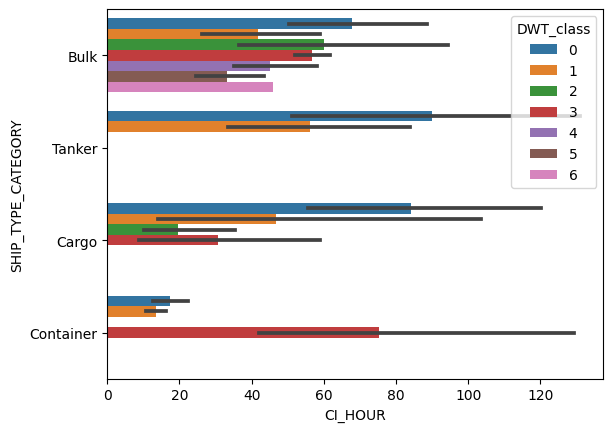

In [ ]:
a = train_[train_['ARI_PO'] == 'WAF5']
sns.barplot(x='CI_HOUR', y='SHIP_TYPE_CATEGORY', hue='DWT_class', data=a)

In [ ]:
for PO_name in train_['ARI_PO'].unique():
  a = train_[train_['ARI_PO'] == f'{PO_name}']

  plt.figure(figsize=(8, 8))
  plt.title(f'{PO_name}')
  sns.barplot(x='CI_HOUR', y='SHIP_TYPE_CATEGORY', hue='DWT_class', data=a)

Output hidden; open in https://colab.research.google.com to view.

<Axes: xlabel='CI_HOUR', ylabel='ARI_PO'>

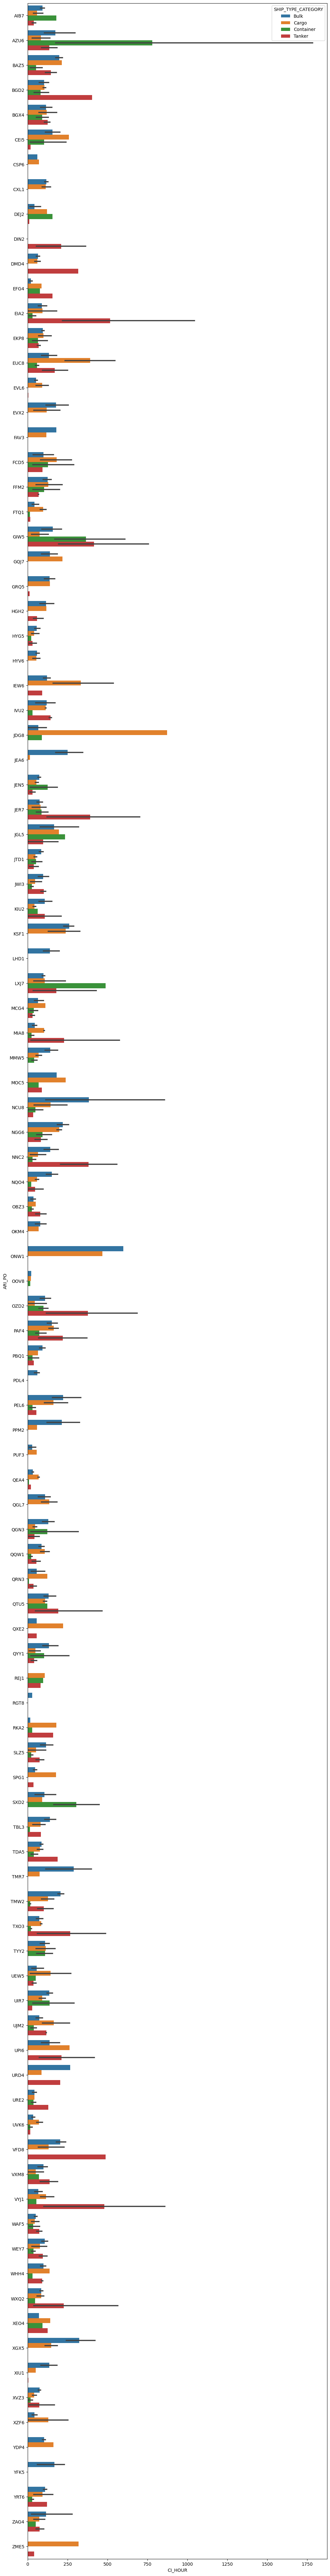

In [ ]:
train_shipcat = train_.groupby(['ARI_PO', 'SHIP_TYPE_CATEGORY', 'DWT_class'])['CI_HOUR'].mean().reset_index()

category_order = train_shipcat['ARI_PO'].unique().tolist()

plt.figure(figsize=(12,len((train_['ARI_PO'].unique()) * 5)))

sns.barplot(x='CI_HOUR', y='ARI_PO', hue='SHIP_TYPE_CATEGORY', data=train_shipcat, order=category_order)

<Axes: xlabel='CI_HOUR', ylabel='ARI_PO'>

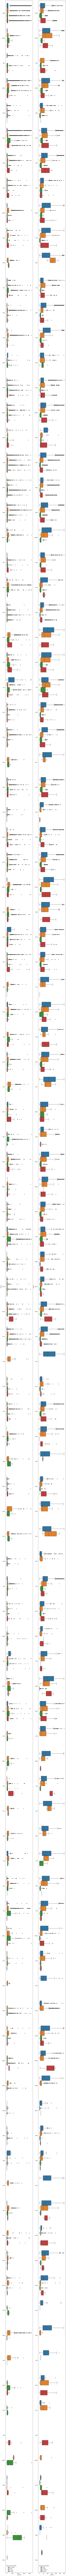

In [ ]:
category_order = train_['ARI_PO'].unique().tolist()

def remove_outliers(group):
    Q1 = group['CI_HOUR'].quantile(0.25)
    Q3 = group['CI_HOUR'].quantile(0.75)
    IQR = Q3 - Q1
    filter = (group['CI_HOUR'] >= Q1 - 1.5 * IQR) & (group['CI_HOUR'] <= Q3 + 1.5 * IQR)
    return group[filter]

cleaned_data = train_.groupby(['SHIP_TYPE_CATEGORY']).apply(remove_outliers).reset_index(drop=True)


plt.figure(figsize=(12, len(train_['ARI_PO'].unique()) * 5))

# Boxplot 그리기
plt.subplot(1, 2, 1)
sns.boxplot(x='CI_HOUR', y='ARI_PO', hue='SHIP_TYPE_CATEGORY', data=train_, order=category_order)

plt.subplot(1, 2, 2)
sns.boxplot(x='CI_HOUR', y='ARI_PO', hue='SHIP_TYPE_CATEGORY', data=cleaned_data, order=category_order)

In [ ]:
cleaned_data

ARI_CO ARI_PO SHIP_TYPE_CATEGORY        DIST       ID  BREADTH  BUILT  \
0          AU   WHH4               Bulk   49.953585  S731836     40.0      7   
1          CN   UVK6               Bulk   18.022495  U334123     30.0     11   
2          CN   TDA5               Bulk   21.887307  R763644     40.0      9   
3          QA   KIU2               Bulk    5.061462  D575432     30.0     11   
4          AU   YDP4               Bulk   11.365442  C866378     40.0     17   
...       ...    ...                ...         ...      ...      ...    ...   
210688     VN   QRN3             Tanker   11.092085  H613187     20.0     10   
210689     SG   GIW5             Tanker   18.841177  N365637     30.0      9   
210690     SG   GIW5             Tanker   32.339698  V226478     10.0     10   
210691     CN   EUC8             Tanker  144.270496  T133353     20.0     15   
210692     JP   ZAG4             Tanker    7.670807  N847846     10.0     31   

        DEADWEIGHT  DEPTH  DRAUGHT     GT  LENGTH SHIPMANAGER  \
0           183000   20.0     20.0  94100   290.0      HZUO14   
1            35000   20.0     10.0  22500   180.0      KLJL33   
2            70400   20.0     10.0  54600   220.0      HULF38   
3            56800   20.0     10.0  33000   190.0      IOSS33   
4            99300   20.0     10.0  55300   250.0      IBFB81   
...            ...    ...      ...    ...     ...         ...   
210688        5000   10.0     10.0   2970    90.0      KVEM81   
210689       49700   20.0     10.0  29600   180.0      IIZO58   
210690        1110   10.0      0.0   1070    60.0      WFSW14   
210691        4000   10.0     10.0   3490   100.0      IPFV87   
210692        1150    0.0      0.0    740    60.0      TNVB64   

                    FLAG  U_WIND  V_WIND  AIR_TEMPERATURE        BN  ATA_LT  \
0                  Japan    6.10   -2.84             28.1  4.016217       5   
1             Montenegro   -2.16    1.50             25.6  2.146870      10   
2       Hong Kong, China   -4.88    1.55             21.9  3.347518       5   
3       Hong Kong, China     NaN     NaN              NaN       NaN      10   
4              Indonesia     NaN     NaN              NaN       NaN      17   
...                  ...     ...     ...              ...       ...     ...   
210688           Vietnam   -1.25   -5.24             20.9  3.462811      11   
210689            Panama   -0.57   -0.38             26.8  0.875681       4   
210690         Singapore   -1.55    1.90             26.9  2.049026      22   
210691  Hong Kong, China   -1.11   -2.49             17.7  2.199049      17   
210692      Korea, South   -3.95   -0.71              4.4  2.845752       3   

        PORT_SIZE     CI_HOUR  year  month  day  hour  minute  weekday  \
0        0.000103   68.391389  2021      3    5    18      36        4   
1        0.000520    2.721944  2021      9   23     2      48        3   
2        0.000455    7.374722  2021      5   12    21      35        2   
3        0.000130  105.820278  2015      8   27     7       9        3   
4        0.000026  213.366944  2016     10    8     6      16        5   
...           ...         ...   ...    ...  ...   ...     ...      ...   
210688   0.000068   99.973333  2022      3   31     4      52        3   
210689   0.002615  208.037500  2022      5   24    20      55        1   
210690   0.002615  190.003056  2022      5   15    14      55        6   
210691   0.001614  183.045000  2022      9   27     9      44        1   
210692   0.000356   31.849722  2022      3    5    18      59        5   

        CI_trans DWT_class  
0       4.239763         5  
1       1.314246         0  
2       2.125218         3  
3       4.671148         2  
4       5.367689         3  
...          ...       ...  
210688  4.614856         0  
210689  5.342514         1  
210690  5.252289         0  
210691  5.215180         0  
210692  3.491943         0  

[210693 rows x 29 columns]

### 배의 카테고리별 접안지 크기

<Axes: xlabel='SHIP_TYPE_CATEGORY', ylabel='PORT_SIZE'>

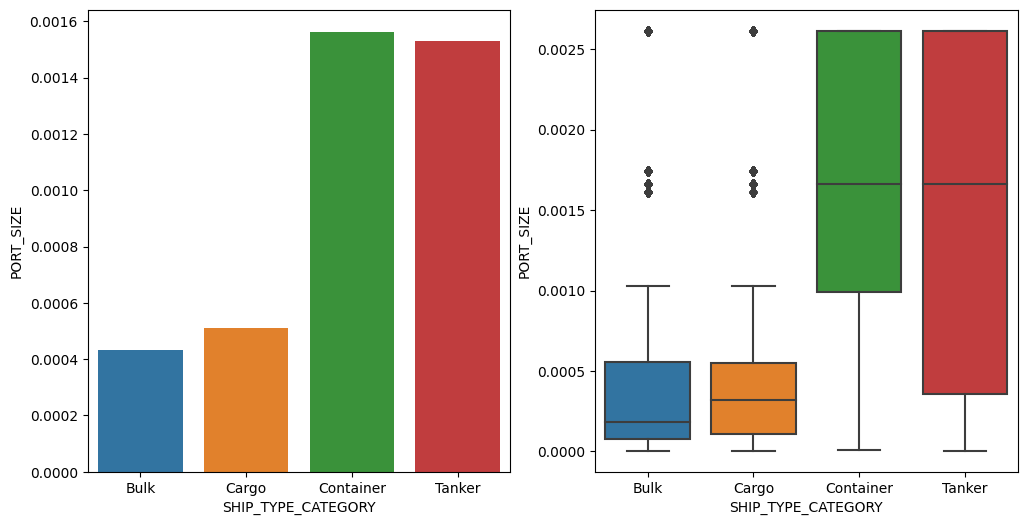

In [ ]:
train_shipcat = train_.groupby(['SHIP_TYPE_CATEGORY'])['PORT_SIZE'].mean().reset_index()

category_order = train_shipcat['SHIP_TYPE_CATEGORY'].tolist()

plt.figure(figsize=(12,6))

plt.subplot(1, 2, 1)
sns.barplot(x='SHIP_TYPE_CATEGORY', y='PORT_SIZE', data=train_shipcat, order=category_order)

plt.subplot(1, 2, 2)
sns.boxplot(x='SHIP_TYPE_CATEGORY', y='PORT_SIZE', data=train_, showfliers=True, order=category_order)

In [ ]:
grouped = train_.groupby(['SHIP_TYPE_CATEGORY', 'DWT_class']).agg({'PORT_SIZE': 'mean', 'CI_HOUR': 'mean'}).reset_index()
grouped['PORT_SIZE'] = grouped['PORT_SIZE'] * 1000000
grouped

SHIP_TYPE_CATEGORY  DWT_class    PORT_SIZE     CI_HOUR
0                Bulk          0   489.875993  108.421608
1                Bulk          1   663.511890  112.608968
2                Bulk          2   584.661763  100.792501
3                Bulk          3   387.500544  131.228082
4                Bulk          4   346.794294  112.556722
5                Bulk          5   331.674103  106.568720
6                Bulk          6   347.002883  111.984947
7               Cargo          0   508.566088  123.148575
8               Cargo          1   511.140703  107.156729
9               Cargo          2   629.236697   98.239262
10              Cargo          3   761.736132  103.095975
11          Container          0  1462.679741   61.030801
12          Container          1  1692.622805   89.741345
13          Container          2  1581.426367   98.714369
14          Container          3  1708.818045   93.068627
15          Container          4  1790.878360  128.974014
16          Container          5  2097.203022  349.548484
17          Container          6  2071.646929  531.185939
18             Tanker          0  1554.291714   89.724907
19             Tanker          1  1249.848462  191.100152
20             Tanker          2   474.203350  117.305764
21             Tanker          3  1461.480394  164.875527
22             Tanker          4  1676.220669  175.694811
23             Tanker          6  1484.121891  253.949854

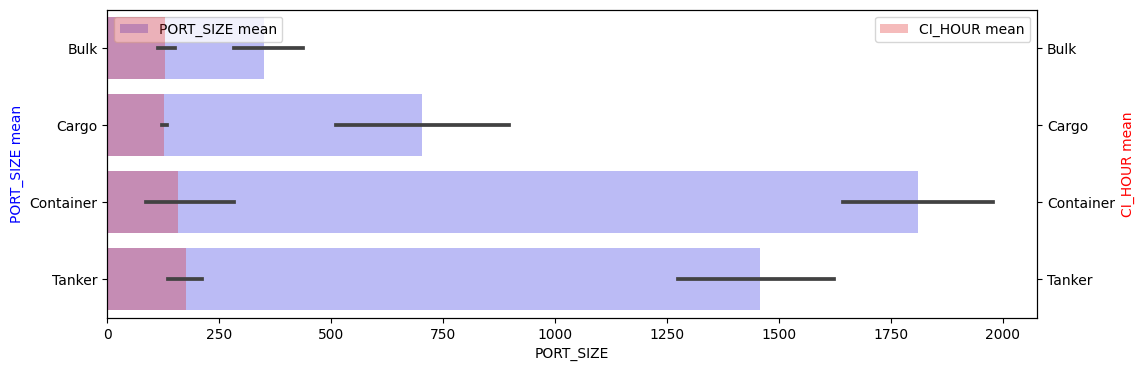

In [ ]:
plt.figure(figsize=(12,len(train_['SHIP_TYPE_CATEGORY'].unique())))

# 첫 번째 Y 축 (DIST에 대한 바 차트)
ax1 = sns.barplot(x='PORT_SIZE', y='SHIP_TYPE_CATEGORY', data=grouped, color='blue', alpha=0.3, label='PORT_SIZE mean')
ax1.set_ylabel('PORT_SIZE mean', color='blue')
ax1.legend(loc='upper left')

# 두 번째 Y 축 (CI_HOUR에 대한 바 차트)
ax2 = ax1.twinx()
sns.barplot(x='CI_HOUR', y='SHIP_TYPE_CATEGORY', data=grouped, color='red', alpha=0.3, ax=ax2, label='CI_HOUR mean')
ax2.set_ylabel('CI_HOUR mean', color='red')
ax2.legend(loc='upper right')

# plt.title('항구별 DIST와 CI_HOUR 평균')
plt.show()

### 배 카테고리별 배의 크기

<Axes: xlabel='SHIP_TYPE_CATEGORY', ylabel='ship_size'>

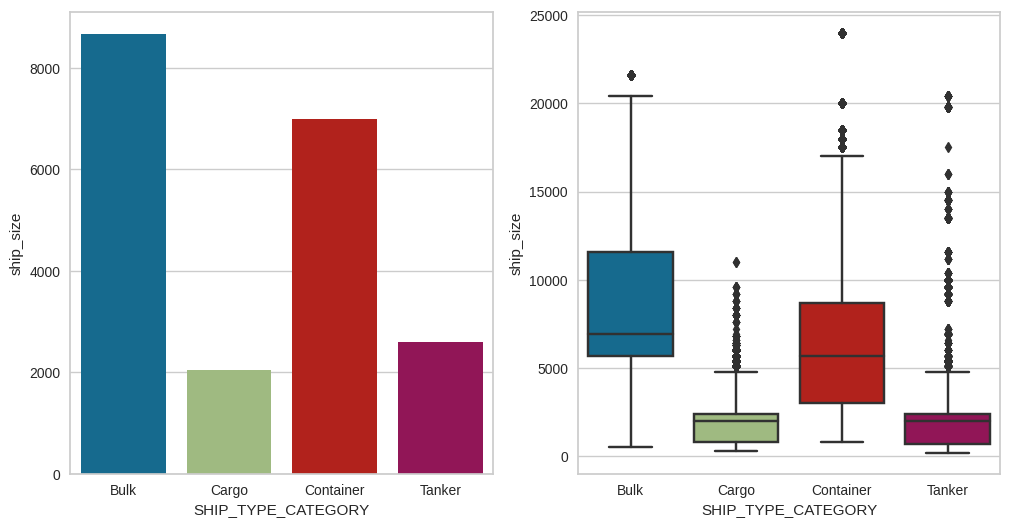

In [ ]:
train_['ship_size'] = train_['BREADTH'] * train_['LENGTH']

train_shipcat = train_.groupby(['SHIP_TYPE_CATEGORY'])['ship_size'].mean().reset_index()

category_order = train_shipcat['SHIP_TYPE_CATEGORY'].tolist()

plt.figure(figsize=(12,6))

plt.subplot(1, 2, 1)
sns.barplot(x='SHIP_TYPE_CATEGORY', y='ship_size', data=train_shipcat, order=category_order)

plt.subplot(1, 2, 2)
sns.boxplot(x='SHIP_TYPE_CATEGORY', y='ship_size', data=train_, showfliers=True, order=category_order)

In [ ]:
import numpy as np

sorted_unique_values = np.sort((train['PORT_SIZE'] * 1000).unique())
print(sorted_unique_values)

[0.0045   0.00458  0.00555  0.00571  0.00604  0.00645  0.00811  0.00829
 0.00975  0.0106   0.0113   0.0119   0.012    0.0155   0.0164   0.0174
 0.0254   0.0257   0.0258   0.0263   0.0291   0.0305   0.0323   0.0365
 0.0366   0.0387   0.0394   0.0408   0.0411   0.0421   0.0426   0.0441
 0.0445   0.0477   0.0499   0.0515   0.0544   0.0567   0.0575   0.0576
 0.0596   0.0614   0.0625   0.0643   0.066    0.0685   0.0692   0.0701
 0.0744   0.08     0.083    0.0896   0.10323  0.103275 0.106927 0.107428
 0.110384 0.113181 0.116672 0.12408  0.124926 0.127949 0.130486 0.131708
 0.142146 0.145059 0.148811 0.155047 0.176888 0.181866 0.196577 0.206362
 0.216617 0.234797 0.243463 0.24405  0.256045 0.264287 0.32008  0.33199
 0.356118 0.360428 0.398636 0.427115 0.449854 0.455438 0.478875 0.51987
 0.551732 0.556558 0.576536 0.594691 0.617532 0.939155 0.989649 1.02563
 1.027827 1.614168 1.660242 1.742858 2.615416]


<Axes: xlabel='DIST', ylabel='CI_HOUR'>

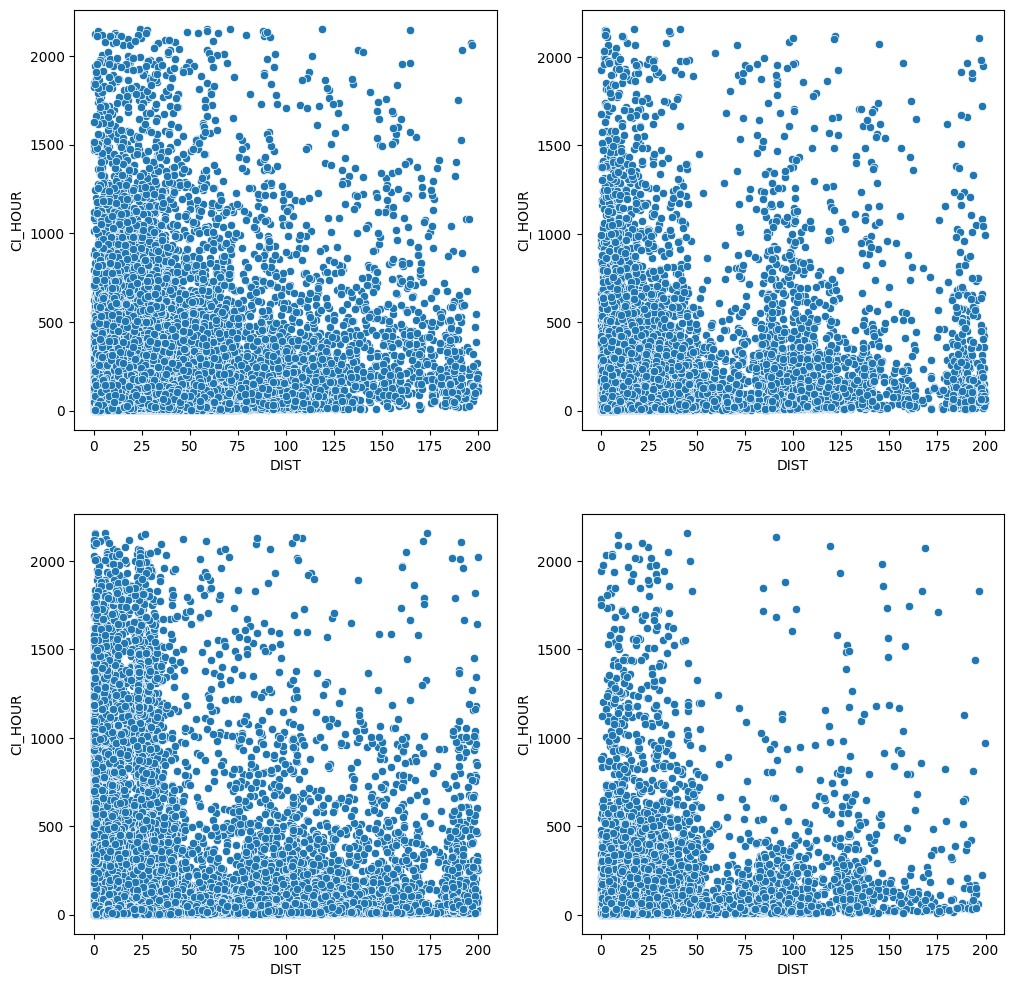

In [ ]:
# train_shipcat = train_.groupby(['SHIP_TYPE_CATEGORY'])['CI_HOUR'].mean().reset_index()

# category_order = train_shipcat['SHIP_TYPE_CATEGORY'].tolist()

ship_bulk = train_[train_['SHIP_TYPE_CATEGORY'] == 'Bulk']
ship_cargo = train_[train_['SHIP_TYPE_CATEGORY'] == 'Cargo']
ship_con = train_[train_['SHIP_TYPE_CATEGORY'] == 'Container']
ship_tank = train_[train_['SHIP_TYPE_CATEGORY'] == 'Tanker']

plt.figure(figsize=(12,12))

plt.subplot(2, 2, 1)
sns.scatterplot(x='DIST', y='CI_HOUR', data=ship_bulk)

plt.subplot(2, 2, 2)
sns.scatterplot(x='DIST', y='CI_HOUR', data=ship_cargo)

plt.subplot(2, 2, 3)
sns.scatterplot(x='DIST', y='CI_HOUR', data=ship_con)

plt.subplot(2, 2, 4)
sns.scatterplot(x='DIST', y='CI_HOUR', data=ship_tank)

# hue='DWT_class',

<Axes: xlabel='ARI_PO', ylabel='DIST'>

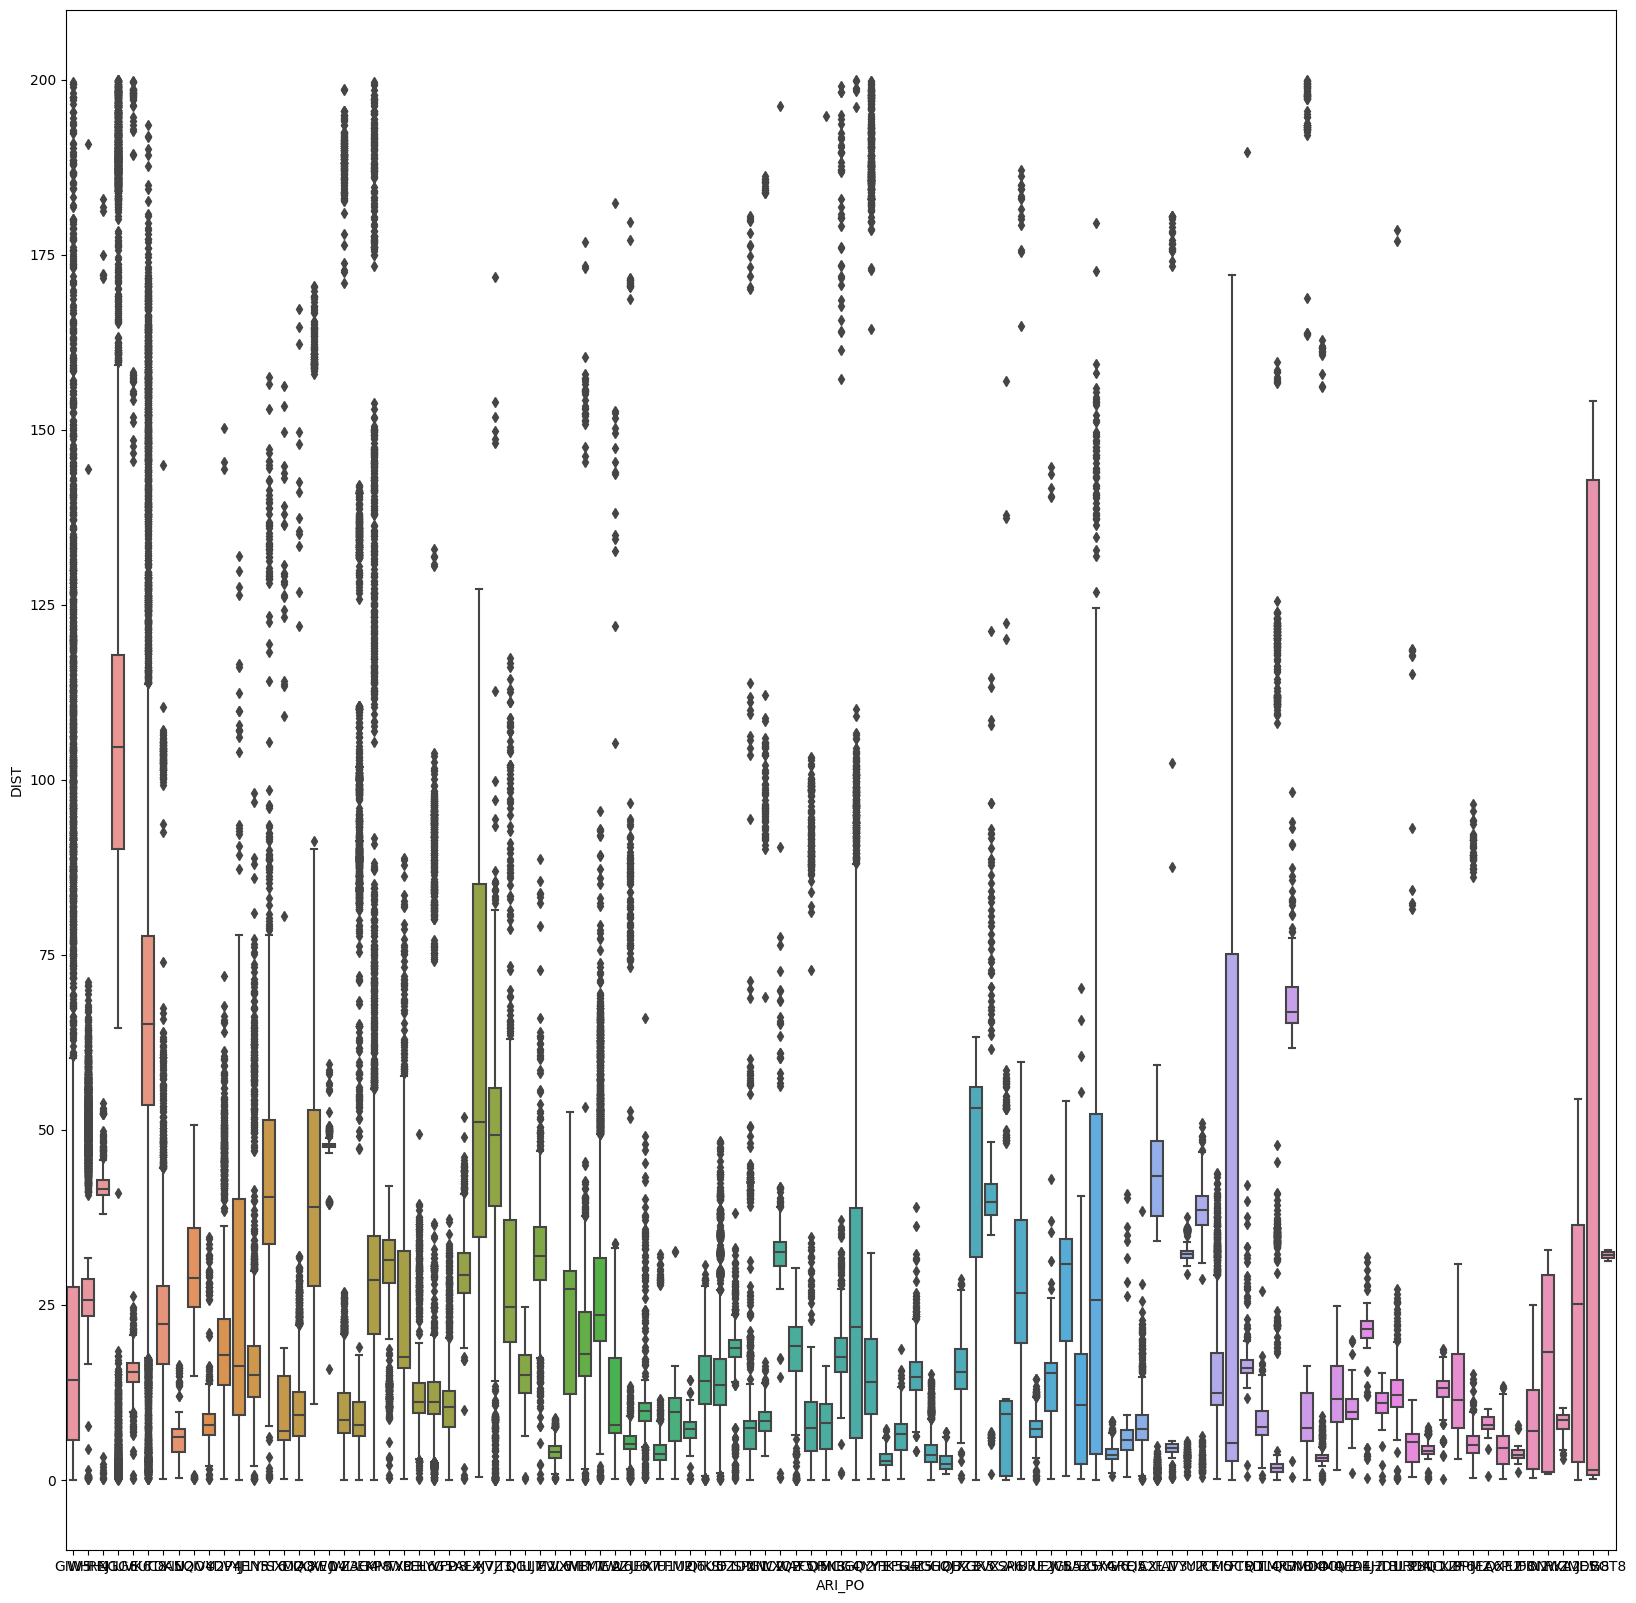

In [ ]:
plt.figure(figsize=(20,20))
sns.boxplot(x='ARI_PO', y='DIST', data=train_)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


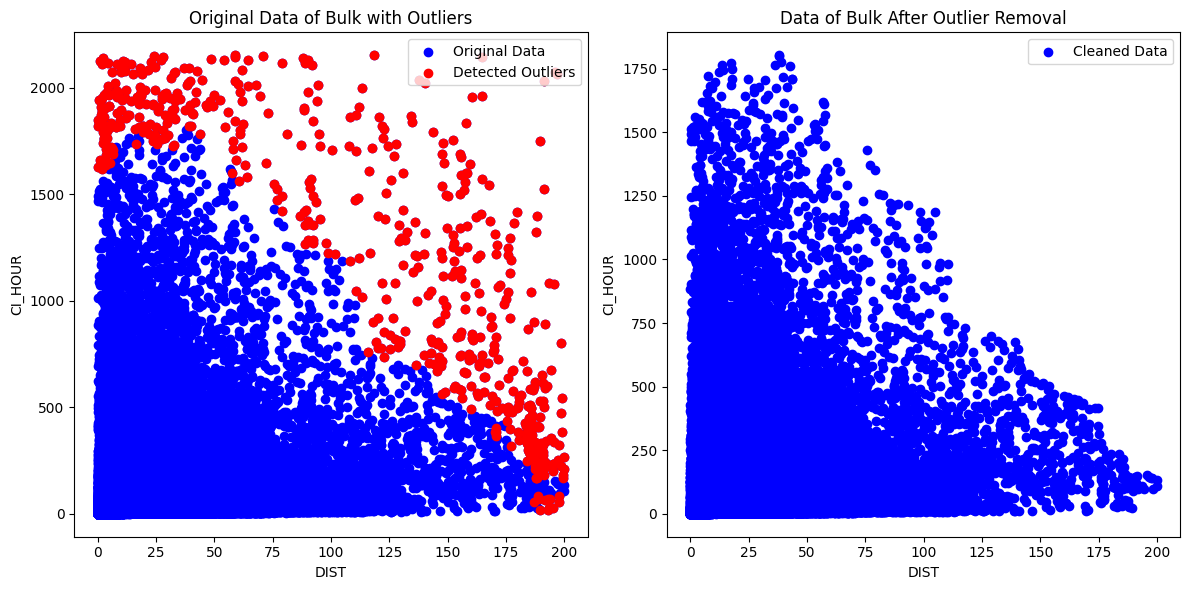

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


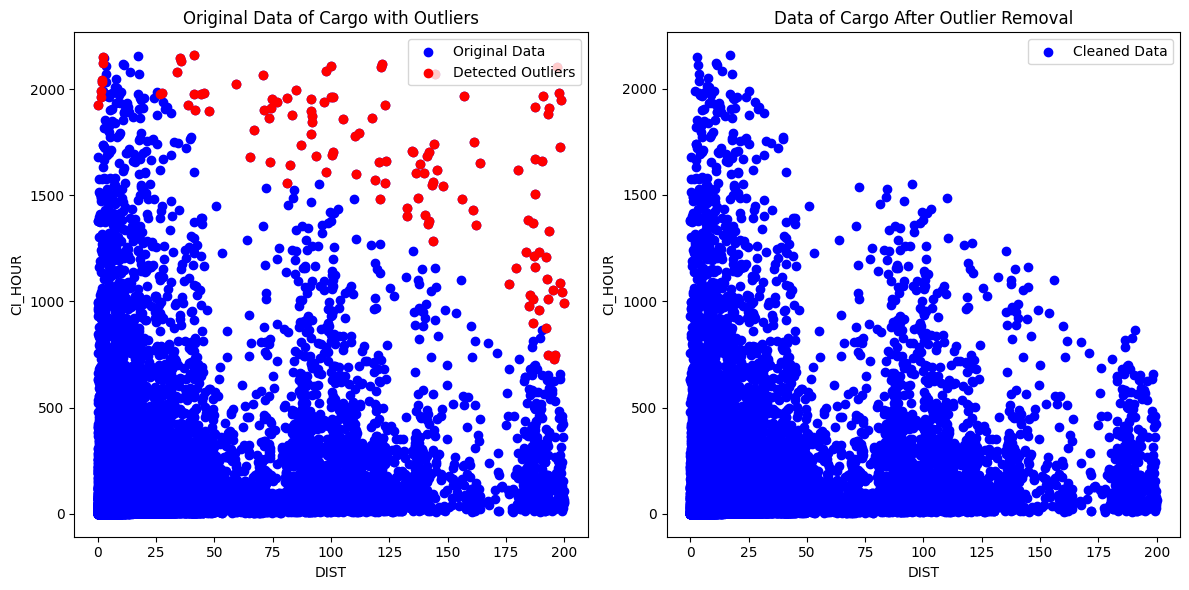

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


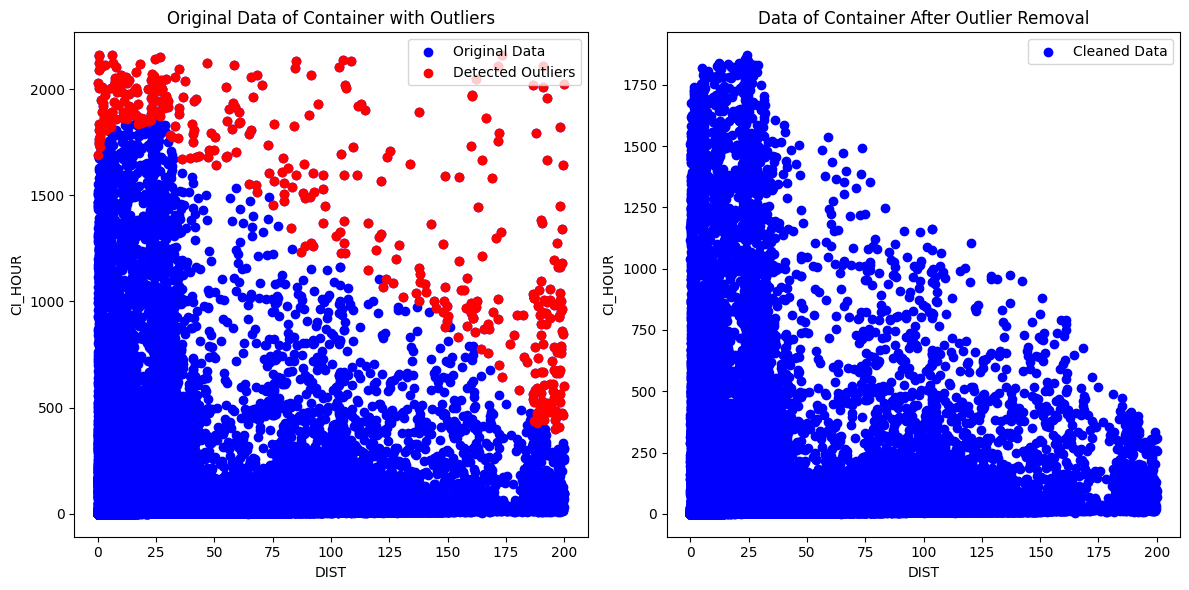

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


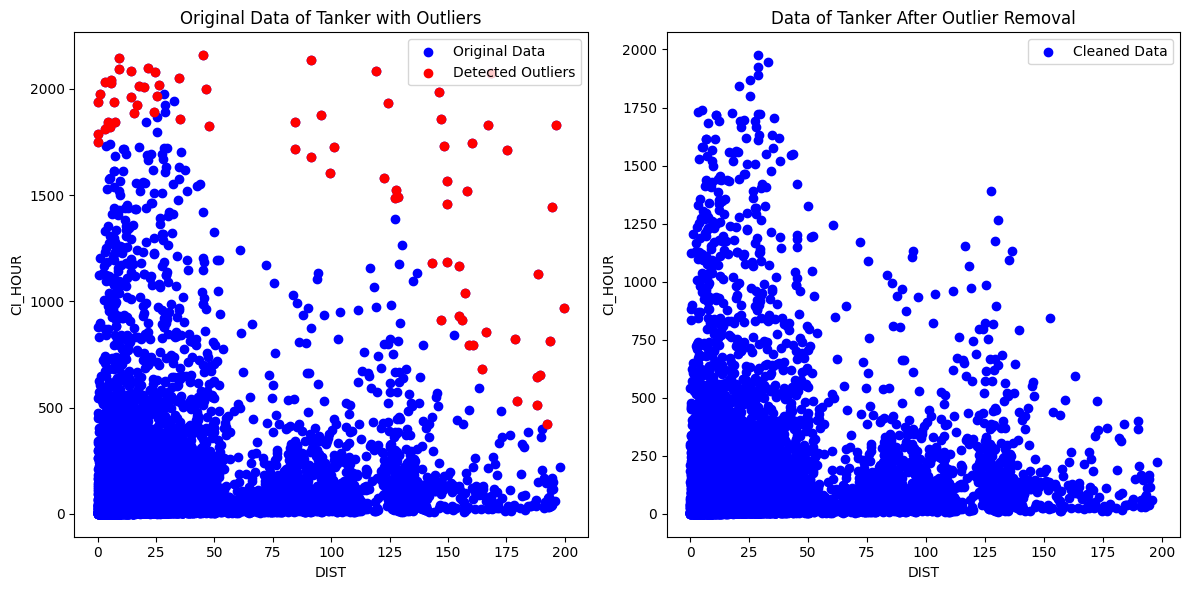

In [ ]:
def remove_outliers_by_category(data, category):
    subset_data = data[data['SHIP_TYPE_CATEGORY'] == category]


    iso_forest = IsolationForest(contamination=0.005)
    labels = iso_forest.fit_predict(subset_data[['DIST', 'CI_HOUR']])
    noise_idx = np.where(labels == -1)[0]

    cleaned_data = subset_data.drop(subset_data.iloc[noise_idx].index).reset_index(drop=True)

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.scatter(subset_data['DIST'], subset_data['CI_HOUR'], c='blue', label='Original Data')
    plt.scatter(subset_data.iloc[noise_idx]['DIST'], subset_data.iloc[noise_idx]['CI_HOUR'], c='red', label='Detected Outliers')
    plt.title(f"Original Data of {category} with Outliers")
    plt.xlabel("DIST")
    plt.ylabel("CI_HOUR")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.scatter(cleaned_data['DIST'], cleaned_data['CI_HOUR'], c='blue', label='Cleaned Data')
    plt.title(f"Data of {category} After Outlier Removal")
    plt.xlabel("DIST")
    plt.ylabel("CI_HOUR")
    plt.legend()

    plt.tight_layout()
    plt.show()

    return cleaned_data

ship_categories = ['Bulk', 'Cargo', 'Container', 'Tanker']
final_data_list = []

for category in ship_categories:
    cleaned_data = remove_outliers_by_category(train_, category)
    final_data_list.append(cleaned_data)

train_data = pd.concat(final_data_list, axis=0).reset_index(drop=True)

## DIST(접안지 까지의 거리) 시각화

In [ ]:
sns.scatterplot(x='DIST', y='CI_HOUR', data=train_)

### 항구별 DIST

In [ ]:
train_['ARI_PO'] = train_['ARI_CO'] + train_['ARI_PO']
test['ARI_PO'] = test['ARI_CO'] + test['ARI_PO']

len(train_['ARI_PO'].unique()), len(train_['PORT_SIZE'].unique())

(103, 100)

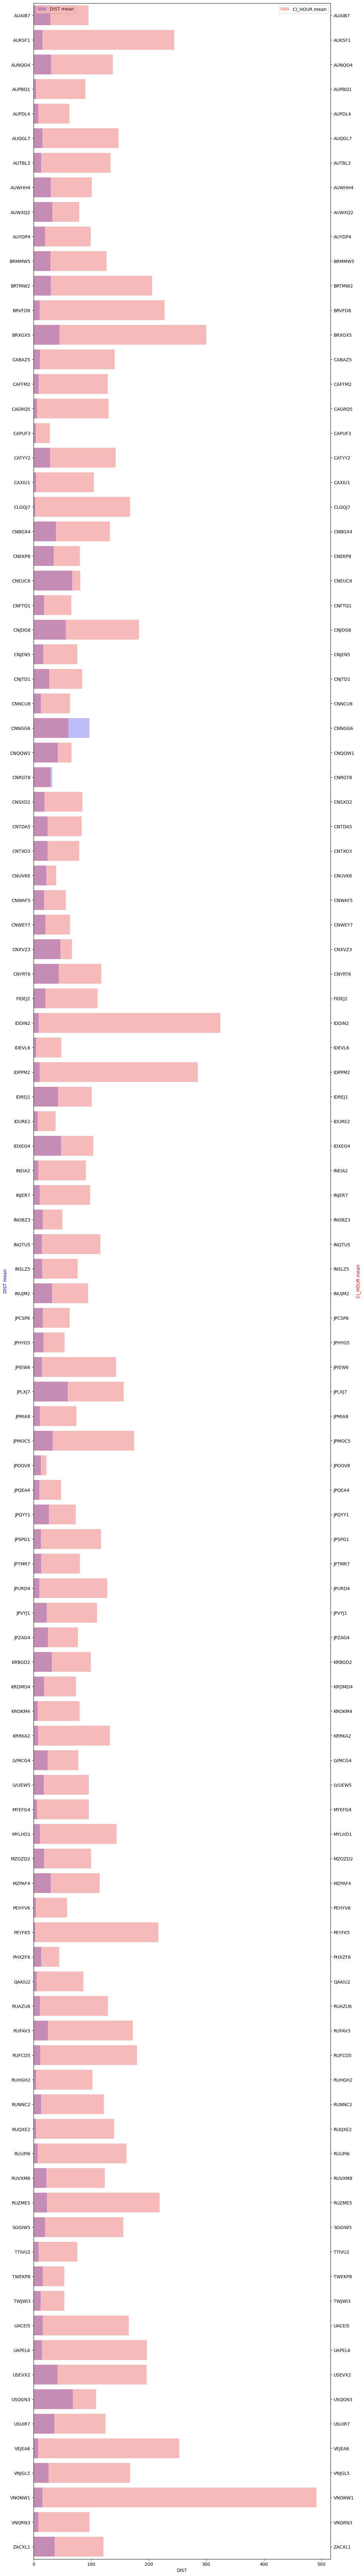

In [ ]:
grouped = train_.groupby('ARI_PO').agg({'DIST': 'mean', 'CI_HOUR': 'mean'}).reset_index()

plt.figure(figsize=(12,len(train_['ARI_PO'].unique())))

# 첫 번째 Y 축 (DIST에 대한 바 차트)
ax1 = sns.barplot(x='DIST', y='ARI_PO', data=grouped, color='blue', alpha=0.3, label='DIST mean')
ax1.set_ylabel('DIST mean', color='blue')
ax1.legend(loc='upper left')

# 두 번째 Y 축 (CI_HOUR에 대한 바 차트)
ax2 = ax1.twinx()
sns.barplot(x='CI_HOUR', y='ARI_PO', data=grouped, color='red', alpha=0.3, ax=ax2, label='CI_HOUR mean')
ax2.set_ylabel('CI_HOUR mean', color='red')
ax2.legend(loc='upper right')

# plt.title('항구별 DIST와 CI_HOUR 평균')
plt.show()

In [ ]:
# grouped 데이터프레임에 CI_per_dist feature 생성
grouped = train_.groupby('ARI_PO').agg({'DIST': 'mean', 'CI_HOUR': 'mean'}).reset_index()

grouped['CI_per_dist'] = grouped['CI_HOUR'] / grouped['DIST']

# CI_per_dist feature를 train_ 데이터프레임에 병합
train_ = train_.merge(grouped[['ARI_PO', 'CI_per_dist']], on='ARI_PO', how='left')

# CI_per_dist feature를 test 데이터프레임에 병합
test = test.merge(grouped[['ARI_PO', 'CI_per_dist']], on='ARI_PO', how='left')

In [ ]:
train_

ARI_CO  ARI_PO SHIP_TYPE_CATEGORY        DIST       ID  BREADTH  BUILT  \
0          SG  SGGIW5          Container   30.881018  Z618338     30.0     24   
1          SG  SGGIW5          Container   27.037650  A872328     50.0     10   
2          AU  AUWHH4               Bulk   49.953585  S731836     40.0      7   
3          ID  IDREJ1          Container   42.276281  A735263     20.0     30   
4          CN  CNNGG6          Container  101.521598  S458225     50.0      7   
...       ...     ...                ...         ...      ...      ...    ...   
234669     CN  CNWAF5               Bulk   21.866691  V427658     40.0     13   
234670     CN  CNNCU8               Bulk    9.647703  H321245     30.0     26   
234671     SG  SGGIW5               Bulk    5.884603  K635567     10.0     12   
234672     US  USQGN3               Bulk   70.660241  J284147     30.0      8   
234673     TW  TWJWI3          Container    9.448179  J644215     30.0     29   

        DEADWEIGHT  DEPTH  DRAUGHT      GT  LENGTH SHIPMANAGER  \
0            24300   10.0     10.0   16700   180.0      CQSB78   
1           116000   20.0     10.0   96600   300.0      GUCE76   
2           183000   20.0     20.0   94100   290.0      HZUO14   
3             6800   10.0     10.0    4810   110.0      HCOS27   
4           124000   30.0     20.0  111000   320.0      YLMR26   
...            ...    ...      ...     ...     ...         ...   
234669      169000   20.0     20.0   89400   290.0      TNIW71   
234670       69000   20.0     10.0   35900   220.0      PPMJ71   
234671        3160   10.0     10.0    1600    80.0      JLTM64   
234672       60300   20.0     10.0   34800   200.0      YERJ68   
234673       23800   10.0     10.0   16900   170.0      HCZK58   

                    FLAG  U_WIND  V_WIND  AIR_TEMPERATURE        BN  ATA_LT  \
0                 Panama     NaN     NaN              NaN       NaN       5   
1                Liberia   -0.33   -3.28             25.6  2.495953      15   
2                  Japan    6.10   -2.84             28.1  4.016217       5   
3              Indonesia     NaN     NaN              NaN       NaN      10   
4         United Kingdom     NaN     NaN              NaN       NaN       3   
...                  ...     ...     ...              ...       ...     ...   
234669  Marshall Islands     NaN     NaN              NaN       NaN      23   
234670            Panama    3.64    3.44             21.4  3.298553      21   
234671           Vietnam   -0.66    0.97             27.3  1.253491       8   
234672         Singapore   -3.44    7.99             21.1  4.766257      18   
234673           Comoros     NaN     NaN              NaN       NaN      15   

        PORT_SIZE      CI_HOUR  year  month  day  hour  minute  weekday  \
0        0.002615     3.450000  2018     12   17    21      29        0   
1        0.002615   253.554444  2020      1   26     7      51        6   
2        0.000103    68.391389  2021      3    5    18      36        4   
3        0.000041    31.700556  2016     12   11     3       0        6   
4        0.001743    58.193056  2018     11   30    19      29        4   
...           ...          ...   ...    ...  ...   ...     ...      ...   
234669   0.000618    89.884167  2017      6    1    15      27        3   
234670   0.000939  1095.597222  2020      3    2    13      37        0   
234671   0.002615   144.061389  2019     10   16     0      36        2   
234672   0.000155    41.482222  2021      3   23    22      35        1   
234673   0.000990     7.485278  2015      1    8     7      15        3   

        CI_trans DWT_class  CI_per_dist  
0       1.492904         0     7.761918  
1       5.539515         4     7.761918  
2       4.239763         5     3.386105  
3       3.487392         0     2.354838  
4       4.080804         4     0.621056  
...          ...       ...          ...  
234669  4.509586         4     3.107457  
234670  6.999967         3     4.948811  
234671  4.977

In [ ]:
train['new1'] = train['BREADTH'] + train['DEPTH'] + train['DRAUGHT'] + train['LENGTH']
test['new1'] = test['BREADTH'] + test['DEPTH'] + test['DRAUGHT'] + test['LENGTH']

train['ship_size'] = train['BREADTH'] * train['LENGTH']
test['ship_size'] = test['BREADTH'] * test['LENGTH']

In [ ]:
test_ = test[test['DIST'] != 0].reset_index(drop=True)
# test_ = test_[test_['SHIPMANAGER'] != 'AGWE38']
# test_ = test_[test_['SHIPMANAGER'] != 'KQMD74']
# test_ = test_[test_['FLAG'] != 'Togo False']
# test_ = test_[test_['FLAG'] != 'Panama']

test_

ARI_CO  ARI_PO SHIP_TYPE_CATEGORY        DIST       ID  BREADTH  BUILT  \
0          SG  SGGIW5          Container    1.826589  K322654     50.0     18   
1          CN  CNWEY7              Cargo   25.399386  E376681     10.0     13   
2          CN  CNNGG6          Container  111.079467  F811111     20.0     26   
3          CA  CAFFM2               Bulk    9.175258  A737561     30.0      9   
4          IN  INUJM2               Bulk   15.568616  N677182     30.0     15   
...       ...     ...                ...         ...      ...      ...    ...   
132056     RU  RUNNC2               Bulk    9.984928  O783254     40.0      3   
132057     BR  BRTMW2               Bulk   21.712733  E731427     60.0     15   
132058     CA  CAGRQ5               Bulk    4.870490  Q434522     30.0      9   
132059     JP  JPVYJ1             Tanker   17.068286  U148516     10.0     14   
132060     MZ  MZPAF4          Container   32.280098  N282778     30.0     35   

        DEADWEIGHT  DEPTH  DRAUGHT      GT  LENGTH SHIPMANAGER  \
0           117000   30.0     20.0  109000   340.0      KQMD74   
1             3810   10.0     10.0    2560    80.0      LBYS27   
2            10900   10.0     10.0    8440   140.0      EKFV15   
3            55800   20.0     10.0   31500   190.0      MASW32   
4            58800   20.0     10.0   32400   190.0      ZAKR16   
...            ...    ...      ...     ...     ...         ...   
132056      121000   20.0     10.0   66800   260.0      RLEZ56   
132057      298000   30.0     20.0  151000   330.0      UWHE18   
132058       80500   20.0     10.0   42700   220.0      BBXV46   
132059        1200    0.0      0.0     500    60.0      DYUA26   
132060       41800   20.0     10.0   31400   200.0      TQXV21   

                    FLAG  U_WIND  V_WIND  AIR_TEMPERATURE        BN  ATA_LT  \
0                 Panama    0.37    1.63             27.1  1.587063      19   
1                 Belize   -2.79   -2.33             14.2  2.663972       6   
2              Singapore    0.04   -4.91              9.3  3.255315       8   
3                 Panama     NaN     NaN              NaN       NaN       2   
4       Marshall Islands    9.86    5.63             36.3  5.692442      10   
...                  ...     ...     ...              ...       ...     ...   
132056  Hong Kong, China   -1.09   -2.59            -11.2  2.243892      22   
132057             Japan     NaN     NaN              NaN       NaN      13   
132058           Liberia     NaN     NaN              NaN       NaN      13   
132059             Japan   -2.87    1.22             27.4  2.405268      23   
132060            Panama     NaN     NaN              NaN       NaN       8   

        PORT_SIZE  year  month  day  hour  minute  weekday DWT_class  \
0        0.002615  2020      6   18    11      58        3         4   
1        0.001028  2021      5   26    22      20        2         0   
2        0.001743  2019     12   16     0       9        0         0   
3        0.000182  2015     11   16     5      30        0         2   
4        0.000217  2022      4   28     4      50        3         2   
...           ...   ...    ...  ...   ...     ...      ...       ...   
132056   0.000197  2022      2   14    20      55        0         4   
132057   0.000080  2017      4    4    15      53        1         6   
132058   0.000039  2016      8   22    16      22        0         3   
132059   0.000264  2022      7   10    14      53        6         0   
132060   0.000054  2015     11    7     6      34        5         1   

        CI_per_dist   new1  ship_size  
0          7.031038  440.0    17000.0  
1          3.736194  110.0      800.0  
2          0.659534  180.0     2800.0  
3         15.107836  250.0     5700.0  
4          3.239750  250.0     5700.0  
...             ...    ...        ...  
132056     9.176516  330.0    10400.0  
132057     7.598233  440.0    19800.0  
132058    25.513930  280.0     6600.0  
132059     5.314365   70.0 

In [ ]:
# train
grouped_mean = train_.groupby(['ARI_CO', 'ARI_PO'])['CI_trans'].mean()
train_['n1'] = train_.set_index(['ARI_CO', 'ARI_PO']).index.map(grouped_mean)
test_['n1'] = test_.set_index(['ARI_CO', 'ARI_PO']).index.map(grouped_mean)

grouped_mean = train_.groupby(['ARI_CO', 'SHIP_TYPE_CATEGORY'])['CI_trans'].mean()
train_['n2'] = train_.set_index(['ARI_CO', 'SHIP_TYPE_CATEGORY']).index.map(grouped_mean)
test_['n2'] = test_.set_index(['ARI_CO', 'SHIP_TYPE_CATEGORY']).index.map(grouped_mean)

grouped_mean = train_.groupby(['ARI_PO', 'SHIP_TYPE_CATEGORY'])['CI_trans'].mean()
train_['n3'] = train_.set_index(['ARI_PO', 'SHIP_TYPE_CATEGORY']).index.map(grouped_mean)
test_['n3'] = test_.set_index(['ARI_PO', 'SHIP_TYPE_CATEGORY']).index.map(grouped_mean)

train_

ARI_CO  ARI_PO SHIP_TYPE_CATEGORY       DIST       ID  BREADTH  BUILT  \
0          SG  SGGIW5          Container  27.037650  A872328     50.0     10   
1          AU  AUWHH4               Bulk  49.953585  S731836     40.0      7   
2          CN  CNUVK6               Bulk  18.022495  U334123     30.0     11   
3          CN  CNTDA5               Bulk  21.887307  R763644     40.0      9   
4          AU  AUNQO4              Cargo  29.624768  Q418441     30.0     27   
...       ...     ...                ...        ...      ...      ...    ...   
134235     AU  AUWHH4               Bulk  55.601755  D468281     50.0      8   
134236     SG  SGGIW5          Container   7.304235  Q875425     40.0      9   
134237     CN  CNNCU8               Bulk   9.647703  H321245     30.0     26   
134238     SG  SGGIW5               Bulk   5.884603  K635567     10.0     12   
134239     US  USQGN3               Bulk  70.660241  J284147     30.0      8   

        DEADWEIGHT  DEPTH  DRAUGHT      GT  LENGTH SHIPMANAGER  \
0           116000   20.0     10.0   96600   300.0      GUCE76   
1           183000   20.0     20.0   94100   290.0      HZUO14   
2            35000   20.0     10.0   22500   180.0      KLJL33   
3            70400   20.0     10.0   54600   220.0      HULF38   
4            55800   20.0     10.0   36000   200.0      GXKR25   
...            ...    ...      ...     ...     ...         ...   
134235      210000   20.0     20.0  107000   300.0      UBYU81   
134236       51700   20.0     10.0   41700   230.0      PIIS74   
134237       69000   20.0     10.0   35900   220.0      PPMJ71   
134238        3160   10.0     10.0    1600    80.0      JLTM64   
134239       60300   20.0     10.0   34800   200.0      YERJ68   

                    FLAG  U_WIND  V_WIND  AIR_TEMPERATURE        BN  ATA_LT  \
0                Liberia   -0.33   -3.28             25.6  2.495953      15   
1                  Japan    6.10   -2.84             28.1  4.016217       5   
2             Montenegro   -2.16    1.50             25.6  2.146870      10   
3       Hong Kong, China   -4.88    1.55             21.9  3.347518       5   
4                Bahamas   -1.25    1.09             20.3  1.578841       9   
...                  ...     ...     ...              ...       ...     ...   
134235           Liberia    6.97    1.47             24.9  4.171745       2   
134236         Singapore   -0.98   -3.79             26.1  2.798925       6   
134237            Panama    3.64    3.44             21.4  3.298553      21   
134238           Vietnam   -0.66    0.97             27.3  1.253491       8   
134239         Singapore   -3.44    7.99             21.1  4.766257      18   

        PORT_SIZE      CI_HOUR  year  month  day  hour  minute  weekday  \
0        0.002615   253.554444  2020      1   26     7      51        6   
1        0.000103    68.391389  2021      3    5    18      36        4   
2        0.000520     2.721944  2021      9   23     2      48        3   
3        0.000455     7.374722  2021      5   12    21      35        2   
4        0.000110    18.007222  2020     11   17    22      41        1   
...           ...          ...   ...    ...  ...   ...     ...      ...   
134235   0.000103    55.701667  2021     10   26    15      41        1   
134236   0.002615    23.914444  2019     12    3    22      51        1   
134237   0.000939  1095.597222  2020      3    2    13      37        0   
134238   0.002615   144.061389  2019     10   16     0      36        2   
134239   0.000155    41.482222  2021      3   23    22      35        1   

        CI_trans DWT_class  CI_per_dist        n1        n2        n3  
0       5.539515         4     7.031038  3.526693  3.328945  3.328945  
1       4.239763         5     3.415244  4.389092  4.476159  4.387830  
2       1.314246         0     1.968140  2.919345  3.951046  3.175208  
3       2.125218         3     3.453807  3.785475  3.951046  3.987511  
4       2.944819         2     5.500575  4.

In [ ]:
def compute_smoothed_means(df, group_cols, target_col, m, global_mean=None):
    if global_mean is None:
        global_mean = df[target_col].mean()

    grouped_mean = df.groupby(group_cols)[target_col].mean()
    grouped_count = df.groupby(group_cols)[target_col].count()

    # 평활화된 평균 계산
    smoothed_means = (grouped_mean * grouped_count + global_mean * m) / (grouped_count + m)
    return smoothed_means

grouped_mean_po = compute_smoothed_means(train_, ['ARI_PO', 'DIST'], 'CI_trans', m=30)  # m 값은 실험적으로 조정 가능
train_['n4'] = train_.set_index(['ARI_PO', 'DIST']).index.map(grouped_mean_po)
test['n4'] = test.set_index(['ARI_PO', 'DIST']).index.map(grouped_mean_po)

In [ ]:
train_.dtypes

ARI_CO                 object
ARI_PO                 object
SHIP_TYPE_CATEGORY     object
DIST                  float64
ID                     object
BREADTH               float64
BUILT                   int64
DEADWEIGHT              int64
DEPTH                 float64
DRAUGHT               float64
GT                      int64
LENGTH                float64
SHIPMANAGER            object
FLAG                   object
U_WIND                float64
V_WIND                float64
AIR_TEMPERATURE       float64
BN                    float64
ATA_LT                  int64
PORT_SIZE             float64
CI_HOUR               float64
year                    int64
month                   int64
day                     int64
hour                    int64
minute                  int64
weekday                 int64
CI_trans              float64
DWT_class              object
CI_per_dist_x         float64
n1                    float64
n2                    float64
n3                    float64
mean_CI_HO

In [ ]:
import torch
import torch.nn as nn
from sklearn.preprocessing import LabelEncoder

# 1. 범주형 변수 레이블 인코딩
label_encoders = {}  # 각 컬럼별로 LabelEncoder를 저장
categorical_columns = ['ARI_CO', 'ARI_PO', 'SHIP_TYPE_CATEGORY', 'DWT_class']

for col in categorical_columns:
    le = LabelEncoder()
    train_[col] = le.fit_transform(train_[col]).astype(int)
    test_[col] = le.transform(test_[col]).astype(int)
    label_encoders[col] = le

# 2. 임베딩 레이어 생성
class CategoricalEmbedding(nn.Module):
    def __init__(self, input_sizes, embedding_dims):
        super(CategoricalEmbedding, self).__init__()

        # 각 범주형 변수에 대한 임베딩 레이어를 생성
        self.embeddings = nn.ModuleList([
            nn.Embedding(input_size, dim) for input_size, dim in zip(input_sizes, embedding_dims)
        ])

    def forward(self, x):
        # x: [batch_size, num_categorical_features]
        embedded = [embedding(x[:, i]) for i, embedding in enumerate(self.embeddings)]
        return torch.cat(embedded, dim=1)  # 연결된 임베딩 벡터 반환

# 각 범주형 변수의 최대값 (레이블 인코딩된 값) + 1을 구함
input_sizes = [train_[col].max() + 1 for col in categorical_columns]

# 임베딩 차원 설정
embedding_dims = [3 for size in input_sizes]

model = CategoricalEmbedding(input_sizes, embedding_dims)

# 모든 행에 대한 범주형 데이터를 PyTorch 텐서로 변환
all_data_tensor = torch.tensor(train_[categorical_columns].values, dtype=torch.long)
all_data_tensor_test = torch.tensor(test_[categorical_columns].values, dtype=torch.long)

# 임베딩 모델에 텐서를 입력하여 임베딩된 값을 얻음
with torch.no_grad():
    all_embedded_values = model(all_data_tensor)
    all_embedded_values_test = model(all_data_tensor_test)

# 임베딩된 텐서를 numpy 배열로 변환
all_embedded_np = all_embedded_values.numpy()
all_embedded_np_test = all_embedded_values_test.numpy()

# 임베딩된 값을 저장할 임시 데이터프레임 생성
embedded_df = pd.DataFrame()
embedded_df_test = pd.DataFrame()


start_idx = 0
# 각 범주형 변수에 대한 임베딩된 값을 새로운 컬럼으로 추가
for i, col in enumerate(categorical_columns):
    col_names = [f"{col}_{j}" for j in range(embedding_dims[i])]
    for idx, name in enumerate(col_names):
        embedded_df[name] = all_embedded_np[:, start_idx + idx]
        embedded_df_test[name] = all_embedded_np_test[:, start_idx + idx]
    start_idx += embedding_dims[i]

# 레이블 인코딩된 컬럼 제거
train_.drop(columns=categorical_columns, inplace=True)
test_.drop(columns=categorical_columns, inplace=True)

# 임베딩된 데이터를 원본 데이터프레임의 앞 부분에 추가
train_ = pd.concat([embedded_df, train_], axis=1)
test_ = pd.concat([embedded_df_test, test_], axis=1)

ValueError: ignored

In [ ]:
train_

ARI_CO_0  ARI_CO_1  ARI_CO_2  ARI_PO_0  ARI_PO_1  ARI_PO_2  \
0      -0.371529 -0.023306  1.979239  0.216185  0.876904  0.817390   
1      -0.371529 -0.023306  1.979239  0.216185  0.876904  0.817390   
2      -0.649625 -0.548841 -0.483310 -0.091319 -0.108211  0.214899   
3      -0.707979 -0.670902 -1.677711  0.477680  0.617326  1.238812   
4      -1.865297 -1.368628  0.810667  0.316947  0.387873 -2.006021   
...          ...       ...       ...       ...       ...       ...   
234669 -1.865297 -1.368628  0.810667 -0.459666 -0.455754  2.030329   
234670 -1.865297 -1.368628  0.810667  0.140244 -0.483325  1.509085   
234671 -0.371529 -0.023306  1.979239  0.216185  0.876904  0.817390   
234672 -0.147584 -0.045344  1.314244  1.166991 -1.488903  0.659104   
234673  1.232544 -1.058082 -0.886154 -0.375751  0.156701 -1.423230   

        SHIP_TYPE_CATEGORY_0  SHIP_TYPE_CATEGORY_1  SHIP_TYPE_CATEGORY_2  \
0                   0.830909             -0.706005             -1.638364   
1                   0.830909             -0.706005             -1.638364   
2                   0.460685              0.936069             -1.433483   
3                   0.830909             -0.706005             -1.638364   
4                   0.830909             -0.706005             -1.638364   
...                      ...                   ...                   ...   
234669              0.460685              0.936069             -1.433483   
234670              0.460685              0.936069             -1.433483   
234671              0.460685              0.936069             -1.433483   
234672              0.460685              0.936069             -1.433483   
234673              0.830909             -0.706005             -1.638364   

        DWT_class_0  DWT_class_1  DWT_class_2        DIST       ID  BREADTH  \
0         -0.606087     0.033487     1.065391   30.881018  Z618338     30.0   
1          0.466346     0.570021     0.810166   27.037650  A872328     50.0   
2          1.573070     0.018131    -1.315091   49.953585  S731836     40.0   
3         -0.606087     0.033487     1.065391   42.276281  A735263     20.0   
4          0.466346     0.570021     0.810166  101.521598  S458225     50.0   
...             ...          ...          ...         ...      ...      ...   
234669     0.466346     0.570021     0.810166   21.866691  V427658     40.0   
234670     1.505982    -2.180816     0.754859    9.647703  H321245     30.0   
234671    -0.606087     0.033487     1.065391    5.884603  K635567     10.0   
234672     1.505982    -2.180816     0.754859   70.660241  J284147     30.0   
234673    -0.606087     0.033487     1.065391    9.448179  J644215     30.0   

        BUILT  DEADWEIGHT  DEPTH  DRAUGHT      GT  LENGTH SHIPMANAGER  \
0          24       24300   10.0     10.0   16700   180.0      CQSB78   
1          10      116000   20.0     10.0   96600   300.0      GUCE76   
2           7      183000   20.0     20.0   94100   290.0      HZUO14   
3          30        6800   10.0     10.0    4810   110.0      HCOS27   
4           7      124000   30.0     20.0  111000   320.0      YLMR26   
...       ...         ...    ...      ...     ...     ...         ...   
234669     13      169000   20.0     20.0   89400   290.0      TNIW71   
234670     26       69000   20.0     10.0   35900   220.0      PPMJ71   
234671     12        3160   10.0     10.0    1600    80.0      JLTM64   
234672      8       60300   20.0     10.0   34800   200.0      YERJ68   
234673     29       23800   10.0     10.0   16900   170.0      HCZK58   

                    FLAG  U_WIND  V_WIND  AIR_TEMPERATURE        BN  ATA_LT  \
0                 Panama     NaN     NaN              NaN       NaN       5   
1                Liberia   -0.33   -3.28             25.6  2.495953      15   
2                  Japan    6.10   -2.84             28.1  4.016217       5   
3              Indonesia     NaN     NaN              NaN       NaN      10   
4         United Kingdom     NaN 

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# 원하는 열의 이름 리스트
numeric_cols = ['DIST', 'BREADTH', 'DEADWEIGHT', 'DEPTH', 'DRAUGHT', 'GT', 'LENGTH', 'PORT_SIZE', 'n1', 'n2', 'n3',	'CI_per_dist']

# MinMaxScaler 객체 초기화
scaler = MinMaxScaler()

# 원하는 열만 스케일링
train_[numeric_cols] = scaler.fit_transform(train_[numeric_cols])
test_[numeric_cols] = scaler.transform(test_[numeric_cols])

train_

ARI_CO  ARI_PO SHIP_TYPE_CATEGORY      DIST       ID  BREADTH  BUILT  \
0           17      89          Container  0.135201  A872328      0.8     10   
1            0       7               Bulk  0.249792  S731836      0.6      7   
2            4      34               Bulk  0.090121  U334123      0.4     11   
3            4      32               Bulk  0.109447  R763644      0.6      9   
4            0       2              Cargo  0.148138  Q418441      0.4     27   
...        ...     ...                ...       ...      ...      ...    ...   
134235       0       7               Bulk  0.278036  D468281      0.8      8   
134236      17      89          Container  0.036525  Q875425      0.6      9   
134237       4      28               Bulk  0.048243  H321245      0.4     26   
134238      17      89               Bulk  0.029426  K635567      0.0     12   
134239      21      96               Bulk  0.353335  J284147      0.4      8   

        DEADWEIGHT     DEPTH  DRAUGHT        GT    LENGTH SHIPMANAGER  \
0         0.286952  0.666667      0.5  0.407220  0.736842      GUCE76   
1         0.452835  0.666667      1.0  0.396665  0.710526      HZUO14   
2         0.086408  0.666667      0.5  0.094364  0.421053      KLJL33   
3         0.174053  0.666667      0.5  0.229892  0.526316      HULF38   
4         0.137905  0.666667      0.5  0.151362  0.473684      GXKR25   
...            ...       ...      ...       ...       ...         ...   
134235    0.519683  0.666667      1.0  0.451129  0.736842      UBYU81   
134236    0.127754  0.666667      0.5  0.175427  0.552632      PIIS74   
134237    0.170587  0.666667      0.5  0.150939  0.526316      PPMJ71   
134238    0.007576  0.333333      0.5  0.006122  0.157895      JLTM64   
134239    0.149047  0.666667      0.5  0.146295  0.473684      YERJ68   

                    FLAG  U_WIND  V_WIND  AIR_TEMPERATURE        BN  ATA_LT  \
0                Liberia   -0.33   -3.28             25.6  2.495953      15   
1                  Japan    6.10   -2.84             28.1  4.016217       5   
2             Montenegro   -2.16    1.50             25.6  2.146870      10   
3       Hong Kong, China   -4.88    1.55             21.9  3.347518       5   
4                Bahamas   -1.25    1.09             20.3  1.578841       9   
...                  ...     ...     ...              ...       ...     ...   
134235           Liberia    6.97    1.47             24.9  4.171745       2   
134236         Singapore   -0.98   -3.79             26.1  2.798925       6   
134237            Panama    3.64    3.44             21.4  3.298553      21   
134238           Vietnam   -0.66    0.97             27.3  1.253491       8   
134239         Singapore   -3.44    7.99             21.1  4.766257      18   

        PORT_SIZE      CI_HOUR  year  month  day  hour  minute  weekday  \
0        1.000000   253.554444  2020      1   26     7      51        6   
1        0.037832    68.391389  2021      3    5    18      36        4   
2        0.197390     2.721944  2021      9   23     2      48        3   
3        0.172713     7.374722  2021      5   12    21      35        2   
4        0.040554    18.007222  2020     11   17    22      41        1   
...           ...          ...   ...    ...  ...   ...     ...      ...   
134235   0.037832    55.701667  2021     10   26    15      41        1   
134236   1.000000    23.914444  2019     12    3    22      51        1   
134237   0.357980  1095.597222  2020      3    2    13      37        0   
134238   1.000000   144.061389  2019     10   16     0      36        2   
134239   0.057661    41.482222  2021      3   23    22      35        1   

        CI_trans DWT_class  CI_per_dist        n1        n2        n3  
0       5.539515         4     0.080028  0.520676  0.359157  0.462918  
1       4.239763         5     0.034848  0.760147  0.669113  0.648563  
2       1.314246         0     0.016766  0.352027  0.527237  0.435965  
3       2.125218         3     0

In [ ]:
# # 결측치 처리
train_.fillna(train_.mean(), inplace=True)
test_.fillna(train_.mean(), inplace=True)

<ipython-input-12-6978ecd7204b>:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  train_co = train_.corr()


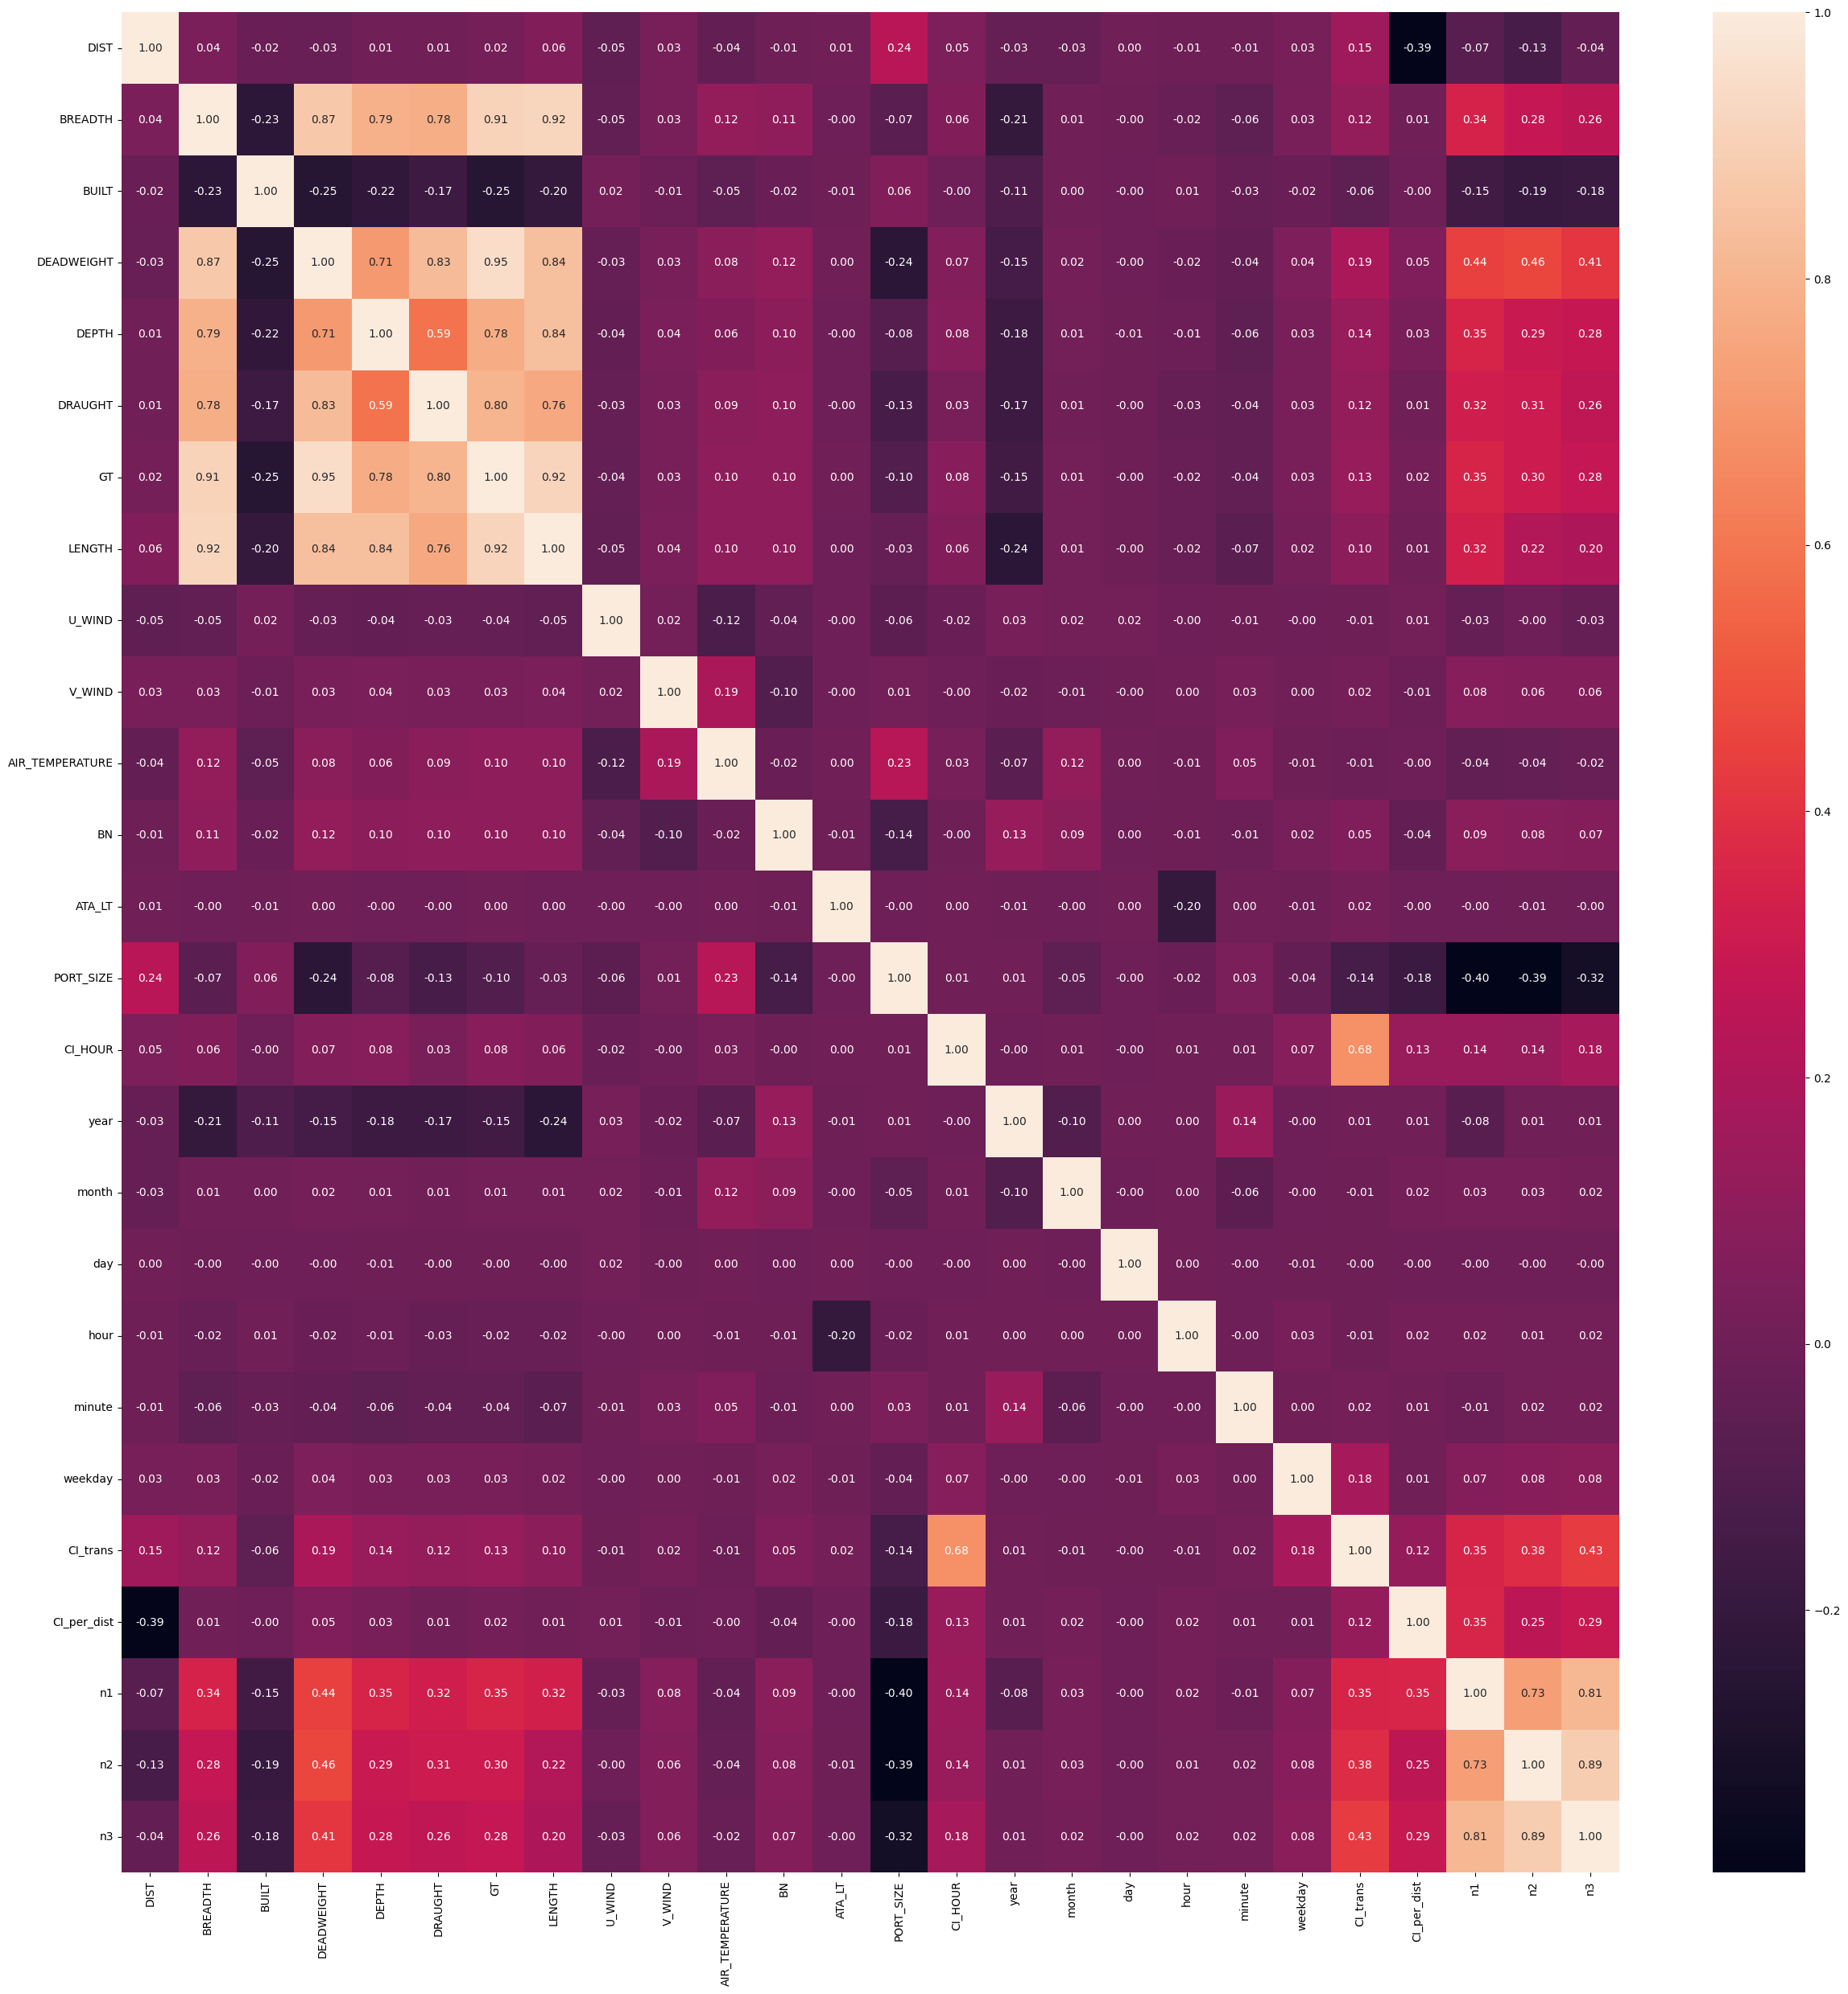

In [ ]:
import seaborn as sns

plt.figure(figsize=(30, 30))

train_co = train_.corr()
sns.heatmap(train_co, annot=True, fmt='.2f', )
plt.show()

KeyError: ignored

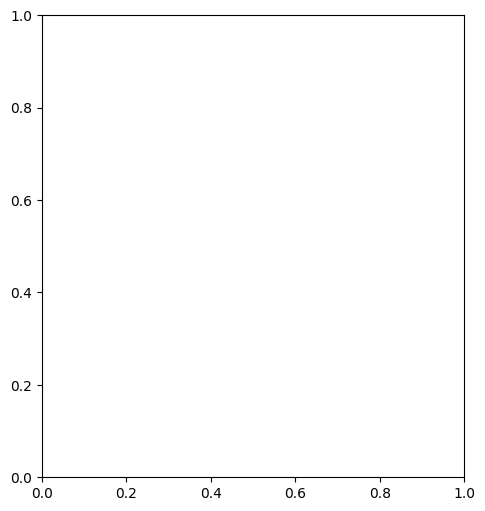

In [ ]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
train_['BN'].hist(bins=100)

plt.subplot(1, 2, 2)
np.sqrt(train_['DIST']).hist(bins=100)

<Axes: xlabel='BN', ylabel='CI_trans'>

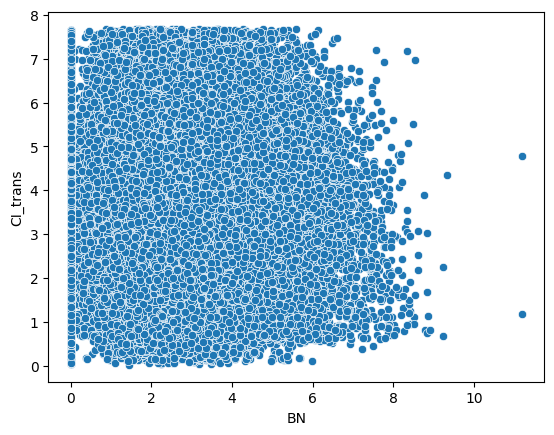

In [ ]:
sns.scatterplot(x='BN', y='CI_trans', data=train_)

In [ ]:
a

year
2014    4.547581
2015    3.777728
2016    3.652423
2017    3.609609
2018    3.417561
2019    3.354088
2020    3.564793
2021    3.663904
2022    3.757046
2023    3.544427
Name: CI_trans, dtype: float64

<Axes: xlabel='weekday', ylabel='CI_trans'>

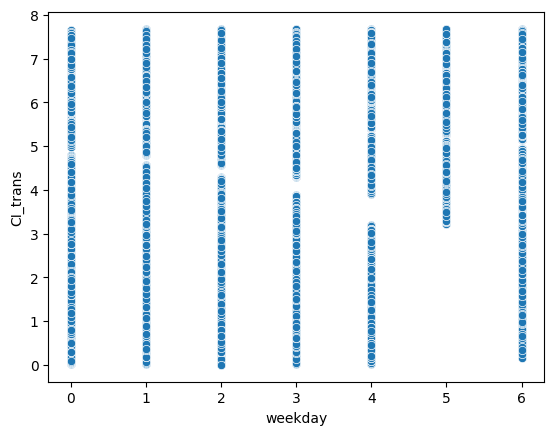

In [ ]:
# 데이터프레임 형식으로 변경
# a = train_.groupby('weekday')['CI_trans'].mean().reset_index()

# 수정된 데이터프레임을 바탕으로 barplot 생성
sns.scatterplot(x='weekday', y='CI_trans', data=train_)

# Pycaret


In [ ]:
# !pip install pycaret[full]

In [ ]:
from pycaret.regression import *

train_data = train_.drop(['CI_HOUR', 'SHIPMANAGER', 'FLAG', 'ID', 'BUILT'], axis=1)

train_data

ARI_CO_0  ARI_CO_1  ARI_CO_2  ARI_PO_0  ARI_PO_1  ARI_PO_2  \
0      -0.217943  0.745985 -0.746162 -2.488443 -1.523950 -1.110808   
1      -0.217943  0.745985 -0.746162 -2.488443 -1.523950 -1.110808   
2      -0.610409 -0.710715 -0.894543  0.592660 -0.087084 -0.190599   
3       0.269684 -0.979615 -0.398237 -1.819670 -0.190783  0.632152   
4      -0.027965 -2.062907  0.187788 -0.372031 -0.175603  1.243781   
...          ...       ...       ...       ...       ...       ...   
234669 -0.027965 -2.062907  0.187788 -0.153830 -0.761670  0.602954   
234670 -0.027965 -2.062907  0.187788 -0.650140  0.719932  1.574837   
234671 -0.217943  0.745985 -0.746162 -2.488443 -1.523950 -1.110808   
234672 -1.528277 -0.549160  0.352520 -1.125680  1.086958  4.073805   
234673 -0.364130  1.130415  1.510242 -0.973261 -0.140934 -1.393879   

        SHIP_TYPE_CATEGORY_0  SHIP_TYPE_CATEGORY_1  SHIP_TYPE_CATEGORY_2  \
0                  -0.652653             -0.677484              0.890058   
1                  -0.652653             -0.677484              0.890058   
2                   0.517377              0.114042             -0.561631   
3                  -0.652653             -0.677484              0.890058   
4                  -0.652653             -0.677484              0.890058   
...                      ...                   ...                   ...   
234669              0.517377              0.114042             -0.561631   
234670              0.517377              0.114042             -0.561631   
234671              0.517377              0.114042             -0.561631   
234672              0.517377              0.114042             -0.561631   
234673             -0.652653             -0.677484              0.890058   

        DWT_class_0  ...  day  hour  minute  weekday  CI_trans  ship_size  \
0          0.781300  ...   17    21      29        0  1.492904   0.168421   
1         -1.087885  ...   26     7      51        6  5.539515   0.589474   
2         -0.305837  ...    5    18      36        4  4.239763   0.426316   
3          0.781300  ...   11     3       0        6  3.487392   0.047368   
4         -1.087885  ...   30    19      29        4  4.080804   0.631579   
...             ...  ...  ...   ...     ...      ...       ...        ...   
234669    -1.087885  ...    1    15      27        3  4.509586   0.426316   
234670     0.506919  ...    2    13      37        0  6.999967   0.210526   
234671     0.781300  ...   16     0      36        2  4.977157   0.000000   
234672     0.506919  ...   23    22      35        1  3.749086   0.189474   
234673     0.781300  ...    8     7      15        3  2.138333   0.157895   

        CI_per_dist        n1        n2        n3  
0          0.098291  0.444575  0.396760  0.452894  
1          0.098291  0.444575  0.396760  0.452894  
2          0.038060  0.709332  0.761633  0.618354  
3          0.023865  0.447558  0.253404  0.460284  
4          0.000000  0.392187  0.342798  0.436001  
...             ...       ...       ...       ...  
234669     0.034224  0.415412  0.619981  0.488264  
234670     0.059570  0.215830  0.619981  0.620485  
234671     0.098291  0.444575  0.586314  0.548365  
234672     0.013414  0.580880  0.768154  0.607440  
234673     0.052746  0.186507  0.000000  0.260190  

[234674 rows x 37 columns]

In [ ]:
model = setup(session_id = 1,data = train_data, target = 'CI_trans', normalize = True, normalize_method = 'zscore', transformation=True) # fold_strategy = 'stratifiedkfold'

# model = setup(session_id = 1,
#               data = train_data,
#               target = 'CI_trans',
#               feature_selection = True,
#               feature_selection_method = 'classic',
#               normalize = True, # 데이터를 표준화
#               normalize_method = 'zscore',
#               imputation_type='iterative',
#               # polynomial_features=True,
#               # numeric_iterative_imputer= 'lightgbm', # 숫자형 변수 결측치 채우기
#               multicollinearity_threshold = 0.9,
#               remove_outliers = True,
#               outliers_method = 'lof', # 이상치를 제거
#               outliers_threshold = 0.05,
#               transformation = True, # 데이터를 변환하여 더 정규화된 분포
#               transformation_method = 'yeo-johnson',
#               pca = True, # 주성분 분석을 통해 차원을 축소
#               pca_method = 'incremental',
#               # fold_strategy = 'stratifiedkfold'
#               )

NameError: ignored

In [ ]:
pycaret_regression_models = compare_models(n_select=3, sort='MAE', include=['lr', 'lasso', 'ridge', 'en', 'lar', 'llar', 'omp', 'br', 'ard', 'par', 'ransac', 'tr', 'huber', 'kr', 'dt', 'rf', 'et', 'ada', 'xgboost', 'lightgbm', 'catboost', 'dummy'])
# 0.8327

NameError: ignored

In [ ]:
blender_3 = blend_models(estimator_list = pycaret_regression_models) # 0.8259

Processing:   0%|          | 0/6 [00:00<?, ?it/s]

In [ ]:
test_data = test_.drop(['U_WIND', 'V_WIND', 'AIR_TEMPERATURE', 'BN', 'SHIPMANAGER', 'FLAG', 'ID', 'BUILT'], axis=1)

test_data

ARI_CO_0  ARI_CO_1  ARI_CO_2  ARI_PO_0  ARI_PO_1  ARI_PO_2  \
0      -0.217943  0.745985 -0.746162 -2.488443 -1.523950 -1.110808   
1      -0.027965 -2.062907  0.187788 -0.419933 -0.080916 -0.882944   
2      -0.027965 -2.062907  0.187788 -0.372031 -0.175603  1.243781   
3       2.214423  0.692699  1.039195  0.794290 -1.201989  0.457888   
4       0.858156 -1.113284 -1.013812  1.562643  1.614966  1.059590   
...          ...       ...       ...       ...       ...       ...   
132056  2.238927 -0.226205 -0.354830 -1.142740 -1.425160 -1.380060   
132057  0.276878 -0.855006 -1.586925 -0.745359  1.817506 -0.059373   
132058  2.214423  0.692699  1.039195  0.475408 -0.660892 -0.191360   
132059  0.148099  1.534448  1.855472 -1.706367  1.313223 -0.682374   
132060 -0.096362 -0.787446 -1.245354  0.464880 -2.536567 -0.010768   

        SHIP_TYPE_CATEGORY_0  SHIP_TYPE_CATEGORY_1  SHIP_TYPE_CATEGORY_2  \
0                  -0.652653             -0.677484              0.890058   
1                   1.702682             -0.713823             -0.316548   
2                  -0.652653             -0.677484              0.890058   
3                   0.517377              0.114042             -0.561631   
4                   0.517377              0.114042             -0.561631   
...                      ...                   ...                   ...   
132056              0.517377              0.114042             -0.561631   
132057              0.517377              0.114042             -0.561631   
132058              0.517377              0.114042             -0.561631   
132059             -0.213022             -0.463972              0.177033   
132060             -0.652653             -0.677484              0.890058   

        DWT_class_0  ...  day  hour  minute  weekday  CI_per_dist   new1  \
0         -1.087885  ...   18    11      58        3     0.098291  440.0   
1          0.781300  ...   26    22      20        2     0.033899  110.0   
2          0.781300  ...   16     0       9        0     0.000000  180.0   
3          0.408907  ...   16     5      30        0     0.195365  250.0   
4          0.408907  ...   28     4      50        3     0.031675  250.0   
...             ...  ...  ...   ...     ...      ...          ...    ...   
132056    -1.087885  ...   14    20      55        0     0.118894  330.0   
132057    -0.802006  ...    4    15      53        1     0.087015  440.0   
132058     0.506919  ...   22    16      22        0     0.293534  280.0   
132059     0.781300  ...   10    14      53        6     0.058208   70.0   
132060     1.503004  ...    7     6      34        5     0.044462  260.0   

              n1        n2        n3  ship_size  
0       0.444575  0.396760  0.452894   0.673684  
1       0.388087  0.565489  0.549547   0.000000  
2       0.392187  0.342798  0.436001   0.063158  
3       0.705347  0.729845  0.627580   0.178947  
4       0.557585  0.581482  0.544331   0.178947  
...          ...       ...       ...        ...  
132056  0.601258  0.592974  0.603211   0.378947  
132057  0.901727  0.910677  0.725668   0.815789  
132058  0.737898  0.729845  0.636409   0.210526  
132059  0.509920  0.402902  0.540041   0.000000  
132060  0.606175  0.478818  0.458232   0.189474  

[132061 rows x 33 columns]

In [ ]:
fianl_model = finalize_model(blender_3)
prediction = predict_model(fianl_model, data = test_data)

In [ ]:
prediction.to_csv('/content/drive/MyDrive/Colab Notebooks/2023_dacon_HDAI/result/dacon_HDAI_pltv2_data.csv', index=False)

submit = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/2023_dacon_HDAI/sample_submission.csv')

test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/2023_dacon_HDAI/test.csv')

# 1. ['DIST']의 값이 0이 아닌 행만 선택하여 새로운 데이터프레임에 저장
test_filtered = test[test['DIST'] != 0]

# 2. 모델을 사용하여 예측 수행 (모델이 이미 학습되었다고 가정)
# predictions = model.predict(test_filtered.drop('target_column', axis=1))  # 'target_column'을 예측하려는 타겟 열 이름으로 대체

# 3. 원래의 test 데이터프레임에 예측값을 삽입
test['predictions'] = None  # 먼저 예측 열을 None 값으로 초기화
test.loc[test_filtered.index, 'predictions'] = prediction['prediction_label']  # 필터링된 테스트 데이터의 인덱스에 예측값 삽입

def generate_predictions(predictions):
    for pred in predictions:
        yield pred

# predictions에 대한 generator 생성
pred_generator = generate_predictions(prediction['prediction_label'])

# test 데이터의 각 행에 대한 예측값을 저장할 리스트 초기화
final_predictions = []

for _, row in test.iterrows():
    if row['DIST'] == 0:
        final_predictions.append(0)  # 'DIST' 값이 0이면 예측값도 0으로 설정
    else:
        final_predictions.append(next(pred_generator))  # 그렇지 않으면 순차적으로 prediction 값을 추출하여 할당

test['predictions'] = final_predictions  # 결과를 test 데이터프레임에 할당

# test['predictions'] = np.expm1(test['predictions'])

submit.iloc[:, 1] = test['predictions']

submit.to_csv('/content/drive/MyDrive/Colab Notebooks/2023_dacon_HDAI/result/dacon_HDAI_pltv2.csv', index=False)

------------------------------------

# mljar

In [ ]:
!pip install mljar-supervised

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.9/126.9 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 79.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 43.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.8/81.8 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.6/409.6 kB 37.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 kB 31.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 74.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 9.7 MB/s eta 0:00:00
  Created wheel for mljar-supervised: filename=mljar_supervise

--------

In [ ]:
from supervised.automl import AutoML

In [ ]:
train_x = train_.drop(["CI_HOUR", "CI_trans", 'SHIPMANAGER', 'FLAG', 'ID'], axis=1)
train_y = train_['CI_trans']

In [ ]:
Cross_validation = {
    "validation_type": "kfold",
    "k_folds": 10,
    "shuffle": True,
    "random_seed": 24 #38
}

automl = AutoML(mode="Compete", n_jobs = -1, eval_metric="mae", validation_strategy=Cross_validation)
automl.fit(train_x, train_y)

Linear algorithm was disabled.
AutoML directory: AutoML_1
The task is regression with evaluation metric mae
AutoML will use algorithms: ['Decision Tree', 'Random Forest', 'Extra Trees', 'LightGBM', 'Xgboost', 'CatBoost', 'Neural Network', 'Nearest Neighbors']
AutoML will stack models
AutoML will ensemble available models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'not_so_random', 'mix_encoding', 'golden_features', 'kmeans_features', 'insert_random_feature', 'features_selection', 'hill_climbing_1', 'hill_climbing_2', 'boost_on_errors', 'ensemble', 'stack', 'ensemble_stacked']
* Step simple_algorithms will try to check up to 3 models
1_DecisionTree mae 0.986543 trained in 19.3 seconds
2_DecisionTree mae 0.963005 trained in 20.39 seconds
3_DecisionTree mae 0.963005 trained in 21.99 seconds
* Step default_algorithms will try to check up to 6 models
4_Default_LightGBM mae 0.820677 trained in 181.87 seconds
5_Default_Xgboost mae 0.826124 trained in 204.61 seconds
6_Default_Cat

KeyboardInterrupt: ignored

# AutoGluon

In [ ]:
pip install autogluon


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.0/224.0 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 285.7/285.7 kB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 372.3/372.3 kB 38.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 85.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.5/58.5 MB 27.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 94.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.4/90.4 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 5.1 MB/s eta 0:00:00
  Preparing metadata (se

In [ ]:
import pandas as pd
from autogluon.tabular import TabularDataset, TabularPredictor

# 데이터 로드
train_data = TabularDataset('/content/drive/MyDrive/Colab Notebooks/2023_dacon_HDAI/train.csv')
test_data = TabularDataset('/content/drive/MyDrive/Colab Notebooks/2023_dacon_HDAI/test.csv')

# 모델의 평가 지표 및 시간 설정
eval_metrics = ['mean_absolute_error']
time_limits = [999999, 999999, 999999]
model_paths = ['/content/drive/MyDrive/Colab Notebooks/2023_dacon_HDAI/AutoGluon/AutogluonModels/model_mae']

all_predictions = []

# 각 평가 지표로 모델 훈련 및 예측
for i, (eval_metric, time_limit, save_path) in enumerate(zip(eval_metrics, time_limits, model_paths)):
    predictor = TabularPredictor(
        label='CI_HOUR',
        path=save_path,
        eval_metric=eval_metric
    ).fit(
        train_data=train_data,
        presets='best_quality',
        time_limit=time_limit
    )

    test_pred = predictor.predict(test_data)
    all_predictions.append(test_pred)

    # submission 파일 저장
    submission = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/2023_dacon_HDAI/sample_submission.csv')
    submission['CI_HOUR'] = test_pred
    submission.to_csv(f'/content/drive/MyDrive/Colab Notebooks/2023_dacon_HDAI/AutoGluon/autogluon_model_{eval_metric}_submit.csv', index=False)

# 모든 모델의 예측값을 앙상블
ensemble_test_pred = sum(all_predictions) / len(all_predictions)

# 앙상블 결과로 submission 파일 저장
final_submission = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/2023_dacon_HDAI/sample_submission.csv')
final_submission['CI_HOUR'] = ensemble_test_pred
final_submission.to_csv('/content/drive/MyDrive/Colab Notebooks/2023_dacon_HDAI/AutoGluon/v1.csv', index=False)


Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 999999s
AutoGluon will save models to "/content/drive/MyDrive/Colab Notebooks/2023_dacon_HDAI/AutoGluon/AutogluonModels/model_mae/"
AutoGluon Version:  0.8.2
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Wed Aug 30 11:19:59 UTC 2023
Disk Space Avail:   10.80 GB / 16.11 GB (67.1%)
Train Data Rows:    391939
Train Data Columns: 22
Label Column: CI_HOUR
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (2159.130556, 0.0, 61.94083, 170.80956)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary

KeyboardInterrupt: ignored

# 모델 2 TABnet

In [ ]:
pip install pytorch-tabnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 1.6 MB/s eta 0:00:00


In [ ]:
pip install wget

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=18c80d635225cc9d813fdab8c73dc9a9dfdef5b0858880eba6374007ea596562
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


In [ ]:
# 각 ARI_PO, SHIP_TYPE_CATEGORY, DWT_class 조합별 CI_HOUR의 평균 계산
grouped_avg = train_.groupby(['ARI_PO', 'SHIP_TYPE_CATEGORY', 'DWT_class'])['CI_HOUR'].mean().reset_index()
grouped_avg = grouped_avg.rename(columns={'CI_HOUR': 'mean_CI_HOUR'})
grouped_avg['mean_CI_HOUR'] = np.log1p(grouped_avg['mean_CI_HOUR'])

# mean_CI_HOUR feature를 train_ 데이터프레임에 병합
train_ = train_.merge(grouped_avg,
                      on=['ARI_PO', 'SHIP_TYPE_CATEGORY', 'DWT_class'],
                      how='left')

test_ = test_.merge(grouped_avg,
                      on=['ARI_PO', 'SHIP_TYPE_CATEGORY', 'DWT_class'],
                      how='left')

In [ ]:
# 각 ARI_PO, SHIP_TYPE_CATEGORY, DWT_class 조합별 CI_HOUR의 평균 계산
grouped_med = train_.groupby(['ARI_PO', 'SHIP_TYPE_CATEGORY', 'DWT_class'])['CI_HOUR'].median().reset_index()
grouped_med = grouped_med.rename(columns={'CI_HOUR': 'median_CI_HOUR'})
grouped_med['median_CI_HOUR'] = np.log1p(grouped_med['median_CI_HOUR'])


# mean_CI_HOUR feature를 train_ 데이터프레임에 병합
train_ = train_.merge(grouped_med,
                      on=['ARI_PO', 'SHIP_TYPE_CATEGORY', 'DWT_class'],
                      how='left')

test_ = test_.merge(grouped_med,
                      on=['ARI_PO', 'SHIP_TYPE_CATEGORY', 'DWT_class'],
                      how='left')

In [ ]:
from pytorch_tabnet.tab_model import TabNetRegressor

import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

import pandas as pd
import numpy as np
np.random.seed(0)


import os
import wget
from pathlib import Path

In [ ]:
test_ = test[test['DIST'] != 0].reset_index(drop=True)
# test_ = test_[test_['SHIPMANAGER'] != 'AGWE38']
# test_ = test_[test_['SHIPMANAGER'] != 'KQMD74']
# test_ = test_[test_['FLAG'] != 'Togo False']
# test_ = test_[test_['FLAG'] != 'Panama']

test_

ARI_CO  ARI_PO SHIP_TYPE_CATEGORY        DIST       ID  BREADTH  BUILT  \
0          SG  SGGIW5          Container    1.826589  K322654     50.0     18   
1          CN  CNWEY7              Cargo   25.399386  E376681     10.0     13   
2          CN  CNNGG6          Container  111.079467  F811111     20.0     26   
3          CA  CAFFM2               Bulk    9.175258  A737561     30.0      9   
4          IN  INUJM2               Bulk   15.568616  N677182     30.0     15   
...       ...     ...                ...         ...      ...      ...    ...   
132056     RU  RUNNC2               Bulk    9.984928  O783254     40.0      3   
132057     BR  BRTMW2               Bulk   21.712733  E731427     60.0     15   
132058     CA  CAGRQ5               Bulk    4.870490  Q434522     30.0      9   
132059     JP  JPVYJ1             Tanker   17.068286  U148516     10.0     14   
132060     MZ  MZPAF4          Container   32.280098  N282778     30.0     35   

        DEADWEIGHT  DEPTH  DRAUGHT      GT  LENGTH SHIPMANAGER  \
0           117000   30.0     20.0  109000   340.0      KQMD74   
1             3810   10.0     10.0    2560    80.0      LBYS27   
2            10900   10.0     10.0    8440   140.0      EKFV15   
3            55800   20.0     10.0   31500   190.0      MASW32   
4            58800   20.0     10.0   32400   190.0      ZAKR16   
...            ...    ...      ...     ...     ...         ...   
132056      121000   20.0     10.0   66800   260.0      RLEZ56   
132057      298000   30.0     20.0  151000   330.0      UWHE18   
132058       80500   20.0     10.0   42700   220.0      BBXV46   
132059        1200    0.0      0.0     500    60.0      DYUA26   
132060       41800   20.0     10.0   31400   200.0      TQXV21   

                    FLAG  U_WIND  V_WIND  AIR_TEMPERATURE        BN ATA_LT  \
0                 Panama    0.37    1.63             27.1  1.587063     19   
1                 Belize   -2.79   -2.33             14.2  2.663972      6   
2              Singapore    0.04   -4.91              9.3  3.255315      8   
3                 Panama     NaN     NaN              NaN       NaN      2   
4       Marshall Islands    9.86    5.63             36.3  5.692442     10   
...                  ...     ...     ...              ...       ...    ...   
132056  Hong Kong, China   -1.09   -2.59            -11.2  2.243892     22   
132057             Japan     NaN     NaN              NaN       NaN     13   
132058           Liberia     NaN     NaN              NaN       NaN     13   
132059             Japan   -2.87    1.22             27.4  2.405268     23   
132060            Panama     NaN     NaN              NaN       NaN      8   

        PORT_SIZE  year     month_sin  month_cos  day hour minute  weekday  \
0        0.002615  2020  1.224647e-16  -1.000000   18   11     58        3   
1        0.001028  2021  5.000000e-01  -0.866025   26   22     20        2   
2        0.001743  2019 -2.449294e-16   1.000000   16    0      9        0   
3        0.000182  2015 -5.000000e-01   0.866025   16    5     30        0   
4        0.000217  2022  8.660254e-01  -0.500000   28    4     50        3   
...           ...   ...           ...        ...  ...  ...    ...      ...   
132056   0.000197  2022  8.660254e-01   0.500000   14   20     55        0   
132057   0.000080  2017  8.660254e-01  -0.500000    4   15     53        1   
132058   0.000039  2016 -8.660254e-01  -0.500000   22   16     22        0   
132059   0.000264  2022 -5.000000e-01  -0.866025   10   14     53        6   
132060   0.000054  2015 -5.000000e-01   0.866025    7    6     34        5   

       DWT_class  mean_CI_HOUR  median_CI_HOUR  CI_per_dist  
0              4      5.492568        1.815322     7.761918  
1              0      4.789707        3.810267     3.083845  
2              0      3.837748        3.259394     0.621056  
3              2      4.833827        4.413825    14.814377  
4              2      4.383229        3.566802     2.9222

In [ ]:
train = train_.drop('CI_trans', axis=1)
train

ARI_CO  ARI_PO SHIP_TYPE_CATEGORY        DIST       ID  BREADTH  BUILT  \
0          SG  SGGIW5          Container   30.881018  Z618338     30.0     24   
1          SG  SGGIW5          Container   27.037650  A872328     50.0     10   
2          AU  AUWHH4               Bulk   49.953585  S731836     40.0      7   
3          ID  IDREJ1          Container   42.276281  A735263     20.0     30   
4          CN  CNNGG6          Container  101.521598  S458225     50.0      7   
...       ...     ...                ...         ...      ...      ...    ...   
234669     CN  CNWAF5               Bulk   21.866691  V427658     40.0     13   
234670     CN  CNNCU8               Bulk    9.647703  H321245     30.0     26   
234671     SG  SGGIW5               Bulk    5.884603  K635567     10.0     12   
234672     US  USQGN3               Bulk   70.660241  J284147     30.0      8   
234673     TW  TWJWI3          Container    9.448179  J644215     30.0     29   

        DEADWEIGHT  DEPTH  DRAUGHT      GT  LENGTH SHIPMANAGER  \
0            24300   10.0     10.0   16700   180.0      CQSB78   
1           116000   20.0     10.0   96600   300.0      GUCE76   
2           183000   20.0     20.0   94100   290.0      HZUO14   
3             6800   10.0     10.0    4810   110.0      HCOS27   
4           124000   30.0     20.0  111000   320.0      YLMR26   
...            ...    ...      ...     ...     ...         ...   
234669      169000   20.0     20.0   89400   290.0      TNIW71   
234670       69000   20.0     10.0   35900   220.0      PPMJ71   
234671        3160   10.0     10.0    1600    80.0      JLTM64   
234672       60300   20.0     10.0   34800   200.0      YERJ68   
234673       23800   10.0     10.0   16900   170.0      HCZK58   

                    FLAG  U_WIND  V_WIND  AIR_TEMPERATURE        BN ATA_LT  \
0                 Panama     NaN     NaN              NaN       NaN      5   
1                Liberia   -0.33   -3.28             25.6  2.495953     15   
2                  Japan    6.10   -2.84             28.1  4.016217      5   
3              Indonesia     NaN     NaN              NaN       NaN     10   
4         United Kingdom     NaN     NaN              NaN       NaN      3   
...                  ...     ...     ...              ...       ...    ...   
234669  Marshall Islands     NaN     NaN              NaN       NaN     23   
234670            Panama    3.64    3.44             21.4  3.298553     21   
234671           Vietnam   -0.66    0.97             27.3  1.253491      8   
234672         Singapore   -3.44    7.99             21.1  4.766257     18   
234673           Comoros     NaN     NaN              NaN       NaN     15   

        PORT_SIZE      CI_HOUR  year     month_sin     month_cos  day hour  \
0        0.002615     3.450000  2018 -2.449294e-16  1.000000e+00   17   21   
1        0.002615   253.554444  2020  5.000000e-01  8.660254e-01   26    7   
2        0.000103    68.391389  2021  1.000000e+00  6.123234e-17    5   18   
3        0.000041    31.700556  2016 -2.449294e-16  1.000000e+00   11    3   
4        0.001743    58.193056  2018 -5.000000e-01  8.660254e-01   30   19   
...           ...          ...   ...           ...           ...  ...  ...   
234669   0.000618    89.884167  2017  1.224647e-16 -1.000000e+00    1   15   
234670   0.000939  1095.597222  2020  1.000000e+00  6.123234e-17    2   13   
234671   0.002615   144.061389  2019 -8.660254e-01  5.000000e-01   16    0   
234672   0.000155    41.482222  2021  1.000000e+00  6.123234e-17   23   22   
234673   0.000990     7.485278  2015  5.000000e-01  8.660254e-01    8    7   

       minute  weekday DWT_class  mean_CI_HOUR  median_CI_HOUR  CI_per_dist  \
0          29        0         0      4.781744        3.370022     7.761918   
1          51        6         4      5.492568        1.815322     7.761918   
2          36        4         5      4.571530        4.276635     3.386105   
3           0        6         0      4.581447     

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_valid = train_test_split(train, test_size=0.2, random_state=42)

# print(f"학습 데이터 크기: {X_train.shape}")
# print(f"검증 데이터 크기: {X_valid.shape}")

target = 'CI_HOUR'

train_indices = X_train.index
valid_indices = X_valid.index

In [ ]:
categorical_columns = []
categorical_dims =  {}
label_encoders = {}  # 학습 데이터에서 사용한 LabelEncoder 객체를 저장할 딕셔너리

for col in train.columns[train.dtypes == object]:
    print(col, train[col].nunique())
    l_enc = LabelEncoder()
    train[col] = train[col].fillna("unknown")
    train[col] = l_enc.fit_transform(train[col].values)
    categorical_columns.append(col)
    categorical_dims[col] = len(l_enc.classes_)

    label_encoders[col] = l_enc  # 저장

# 학습 데이터에서 결측치 처리
for col in train.columns[train.dtypes == 'float64']:
    mean_value = train.loc[train_indices, col].mean()
    train[col].fillna(mean_value, inplace=True)

# 테스트 데이터에 동일한 변환 적용
for col, l_enc in label_encoders.items():
    unknown_mask = ~test[col].isin(l_enc.classes_)
    test = test.loc[~unknown_mask]
    test[col] = l_enc.transform(test[col].values)

for col in train.columns[train.dtypes == 'float64']:
    if col == 'CI_trans':  # CI_trans 열은 건너뛴다
        continue
    mean_value = train.loc[train_indices, col].mean()
    try:
        test[col].fillna(mean_value, inplace=True)  # 학습 데이터에서 계산한 평균을 사용하여 결측치 처리
    except KeyError:
        print(f"{col} not found in test dataset. Skipping.")


ARI_CO 25
ARI_PO 104
SHIP_TYPE_CATEGORY 4
ID 22258
SHIPMANAGER 5933
FLAG 118
ATA_LT 24
hour 24
minute 60
DWT_class 7


<ipython-input-189-6007a4306408>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[col] = l_enc.transform(test[col].values)


CI_HOUR not found in test dataset. Skipping.


In [ ]:
unused_feat = []

features = [ col for col in train.columns if col not in unused_feat+[target]]

cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]

cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]

# define your embedding sizes : here just a random choice
cat_emb_dim = [5, 5, 5, 5, 5, 5, 5, 5, 5, 5]

In [ ]:
clf = TabNetRegressor(cat_dims=cat_dims, cat_emb_dim=cat_emb_dim, cat_idxs=cat_idxs, n_d=100, # 64 100
    n_a=100,
    n_steps=5,
    gamma=1.3,
    n_independent=3,
    n_shared=3,
    epsilon=1e-15,
    momentum=2e-2,
    clip_value=1,
    lambda_sparse=1e-3,
    verbose=1,

    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    mask_type='entmax',)

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


In [ ]:
X_train = train[features].values[train_indices]
y_train = train[target].values[train_indices].reshape(-1, 1)

X_valid = train[features].values[valid_indices]
y_valid = train[target].values[valid_indices].reshape(-1, 1)

In [ ]:
max_epochs = 100

In [ ]:
from pytorch_tabnet.augmentations import RegressionSMOTE
aug = RegressionSMOTE(p=0.2)

In [ ]:
clf.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_name=['train', 'valid'],
    eval_metric=['mae'],
    max_epochs=max_epochs,
    patience=50,
    batch_size=4096, virtual_batch_size=1024,
    num_workers=0,
    drop_last=False,
    augmentations=aug, #aug
)

epoch 0  | loss: 40223.49225| train_mae: 387.86309| valid_mae: 385.45475|  0:00:51s
epoch 1  | loss: 36743.03406| train_mae: 326.39832| valid_mae: 324.74586|  0:01:42s
epoch 2  | loss: 36485.37083| train_mae: 252.8624| valid_mae: 251.94374|  0:02:32s
epoch 3  | loss: 36427.8113| train_mae: 176.17166| valid_mae: 176.13149|  0:03:22s
epoch 4  | loss: 36295.01866| train_mae: 119.80756| valid_mae: 120.02094|  0:04:10s
epoch 5  | loss: 36169.76452| train_mae: 109.04294| valid_mae: 109.51113|  0:05:00s
epoch 6  | loss: 35989.15668| train_mae: 116.25817| valid_mae: 116.63172|  0:05:51s
epoch 7  | loss: 35774.46229| train_mae: 101.83128| valid_mae: 102.76782|  0:06:41s
epoch 8  | loss: 35719.68547| train_mae: 97.41015| valid_mae: 98.58837|  0:07:30s
epoch 9  | loss: 35501.74089| train_mae: 98.49092| valid_mae: 100.78665|  0:08:20s
epoch 10 | loss: 34384.85503| train_mae: 93.91582| valid_mae: 97.76264|  0:09:10s
epoch 11 | loss: 33470.61435| train_mae: 86.31136| valid_mae: 91.06314|  0:10:01s
e

KeyboardInterrupt: ignored

In [ ]:
# Deprecated : best model is automatically loaded at end of fit
# clf.load_best_model()

X_test = test[features].values

preds = clf.predict(X_test)

In [ ]:
preds

array([[1.0346802],
       [3.5596254],
       [3.0844948],
       ...,
       [2.5997033],
       [1.8939106],
       [3.8501444]], dtype=float32)

In [ ]:
# preds.to_csv('/content/drive/MyDrive/Colab Notebooks/2023_dacon_HDAI/result/dacon_HDAI_v6_data.csv', index=False)

submit = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/2023_dacon_HDAI/sample_submission.csv')

submit.iloc[:, 1] = np.expm1(preds)

submit.to_csv('/content/drive/MyDrive/Colab Notebooks/2023_dacon_HDAI/result/dacon_HDAI_v6_.csv', index=False)

ValueError: ignored

# 모델 3

In [ ]:
train_.dtypes

ARI_CO_0                float32
ARI_CO_1                float32
ARI_CO_2                float32
ARI_PO_0                float32
ARI_PO_1                float32
ARI_PO_2                float32
SHIP_TYPE_CATEGORY_0    float32
SHIP_TYPE_CATEGORY_1    float32
SHIP_TYPE_CATEGORY_2    float32
DWT_class_0             float32
DWT_class_1             float32
DWT_class_2             float32
DIST                    float64
ID                       object
BREADTH                 float64
BUILT                     int64
DEADWEIGHT              float64
DEPTH                   float64
DRAUGHT                 float64
GT                      float64
LENGTH                  float64
SHIPMANAGER              object
FLAG                     object
U_WIND                  float64
V_WIND                  float64
AIR_TEMPERATURE         float64
BN                      float64
ATA_LT                    int64
PORT_SIZE               float64
CI_HOUR                 float64
year                      int64
month   

Model Tune for XGB.


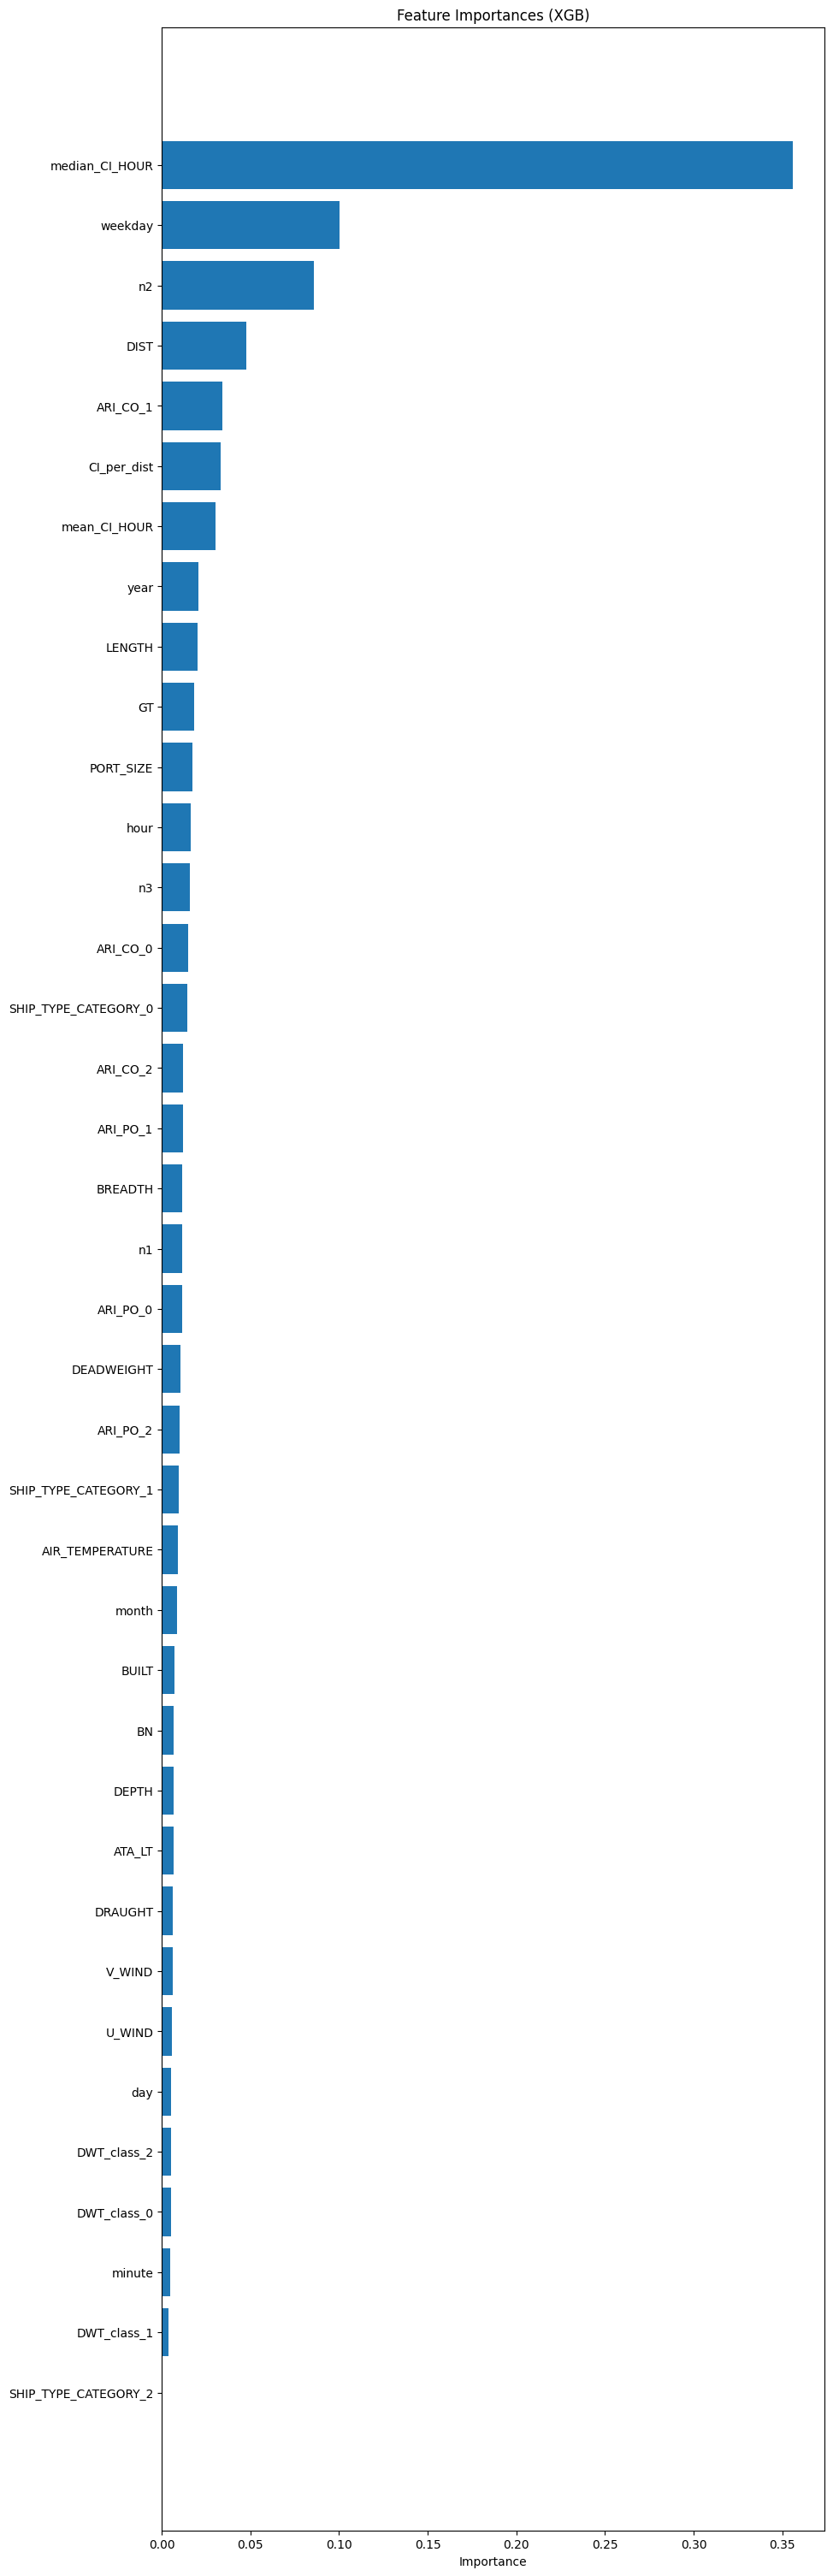

In [ ]:
import xgboost as xgb
# import catboost as cat

def train_and_evaluate(model, model_name, X_train, y_train):
    print(f'Model Tune for {model_name}.')
    model.fit(X_train, y_train)

    feature_importances = model.feature_importances_
    sorted_idx = feature_importances.argsort()

    plt.figure(figsize=(10, len(X_train.columns)))
    plt.title(f"Feature Importances ({model_name})")
    plt.barh(range(X_train.shape[1]), feature_importances[sorted_idx], align='center')
    plt.yticks(range(X_train.shape[1]), X_train.columns[sorted_idx])
    plt.xlabel('Importance')
    plt.show()

    return model, feature_importances

# X_train = filtered_train3.drop(columns='CI_HOUR')
X_train = train_.drop(columns=['CI_HOUR', 'CI_trans', 'SHIPMANAGER', 'FLAG', 'ID'])

y_train = train_['CI_trans']

# Model Tune for LGBM
xgb_model, xgb_feature_importances = train_and_evaluate(xgb.XGBRegressor(), 'XGB', X_train, y_train)

In [ ]:
xgb_feature_importances.sort()
xgb_feature_importances

array([0.        , 0.00385372, 0.00475122, 0.00501771, 0.00512261,
       0.00523762, 0.00548675, 0.00599021, 0.00618887, 0.0066756 ,
       0.00675032, 0.00681522, 0.00717904, 0.00875312, 0.00929328,
       0.00945796, 0.01017352, 0.01028503, 0.01125341, 0.0113859 ,
       0.01166842, 0.01180692, 0.01193405, 0.01434205, 0.01463461,
       0.01561254, 0.01633851, 0.01721701, 0.01802313, 0.02033559,
       0.02085887, 0.03045569, 0.03308029, 0.03392788, 0.0478517 ,
       0.08585487, 0.10023185, 0.3561548 ], dtype=float32)

In [ ]:
threshold = 0.02  # Your Threshold
low_importance_features = X_train.columns[xgb_feature_importances < threshold]

X_train_reduced = X_train.drop(columns=low_importance_features)
X_test_reduced = test_.drop(columns=low_importance_features)

In [ ]:
X_train_reduced

hour  minute  weekday  CI_per_dist        n1        n2        n3  \
0         21      29        0     0.098291  0.444575  0.396760  0.452894   
1          7      51        6     0.098291  0.444575  0.396760  0.452894   
2         18      36        4     0.038060  0.709332  0.761633  0.618354   
3          3       0        6     0.023865  0.447558  0.253404  0.460284   
4         19      29        4     0.000000  0.392187  0.342798  0.436001   
...      ...     ...      ...          ...       ...       ...       ...   
234669    15      27        3     0.034224  0.415412  0.619981  0.488264   
234670    13      37        0     0.059570  0.215830  0.619981  0.620485   
234671     0      36        2     0.098291  0.444575  0.586314  0.548365   
234672    22      35        1     0.013414  0.580880  0.768154  0.607440   
234673     7      15        3     0.052746  0.186507  0.000000  0.260190   

        mean_CI_HOUR  median_CI_HOUR  
0           0.624001        0.427811  
1           0.722786        0.211751  
2           0.594787        0.553805  
3           0.596165        0.371203  
4           0.552994        0.432795  
...              ...             ...  
234669      0.491940        0.397977  
234670      0.932273        0.932273  
234671      0.711802        0.496788  
234672      0.659971        0.579984  
234673      0.426448        0.256426  

[234674 rows x 9 columns]

In [ ]:
pip install optuna

In [ ]:
import optuna
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

X_train_reduced = X_train_reduced.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

X_trn, X_val, y_trn, y_val = train_test_split(X_train_reduced, y_train, test_size=0.2, random_state=42)

def objective(trial):
    # 하이퍼파라미터의 탐색 범위를 지정합니다.
    param = {
        'objective': 'reg:squarederror',
        'n_estimators': trial.suggest_int('n_estimators', 1000, 3000),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'learning_rate': trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 1, step=0.1),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-5, 1e-2, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-5, 1e-2, log=True),
    }

    model = xgb.XGBRegressor(**param)
    model.fit(X_trn, y_trn, eval_set=[(X_val, y_val)], verbose=False)

    y_pred = model.predict(X_val)
    return mean_absolute_error(y_val, y_pred)  # MAE

study = optuna.create_study(direction="minimize")  # MAE를 최소화하도록 설정
study.optimize(objective, n_trials=50)  # 50회의 하이퍼파라미터 탐색

# 파라미터 출력
params_str = ", ".join([f"{k}={v}" for k, v in study.best_params.items()])
print(f"Best trial: score {study.best_value}, params xgb.XGBRegressor({params_str})")


In [ ]:
pip install catboost

In [ ]:
import xgboost as xgb
import catboost as cat

# [I 2023-09-28 14:32:57,315] Trial 1 finished with value: 0.6097263244856379 and parameters: {'n_estimators': 1054, 'max_depth': 12, 'learning_rate': 0.01979073216664539, 'subsample': 0.7638082248832472, 'colsample_bytree': 0.772181710217627, 'gamma': 0.6000000000000001, 'reg_alpha': 0.0005657847311565377, 'reg_lambda': 0.0016173304684546203}. Best is trial 1 with value: 0.6097263244856379.

cat = cat.CatBoostRegressor(
    n_estimators= 3000,
    max_depth= 14,
    learning_rate= 0.06086939849134894,
    subsample= 0.9951874631768192,
    # colsample_bytree= 0.9682987336106713,
    # gamma= 0.9,
    # reg_alpha= 2.3840797712159653e-05,
    reg_lambda= 0.00024246141842562078
                       )

# xgb = xgb.XGBRegressor(
#     objective= 'reg:linear',
#     metrics='mae',
#     n_estimators=20000,
#     max_depth=14,
#     learning_rate=0.01,
#     colsample_bytree=0.9,
#     subsample=0.7,
#     reg_alpha=0.01,
#     reg_lambda=0.01,
#     n_jobs=-1,
#     random_state=42,
#                     )

X_train_reduced = X_train_reduced.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

# 5-Fold 설정
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 각 fold의 모델로부터의 예측을 저장할 리스트와 MAE 점수 리스트
ensemble_predictions = []
scores = []

for train_idx, val_idx in tqdm(kf.split(X_train_reduced), total=5, desc="Processing folds"):
    X_t, X_val = X_train_reduced.iloc[train_idx], X_train_reduced.iloc[val_idx]
    y_t, y_val = y_train[train_idx], y_train[val_idx]

    # 두 모델 모두 학습
    cat.fit(X_t, y_t, eval_set=(X_val, y_val))

    # 각 모델로부터 Validation set에 대한 예측을 평균내어 앙상블 예측 생성
    val_pred = cat.predict(X_val)

    # Validation set에 대한 대회 평가 산식 계산 후 저장
    scores.append(mean_absolute_error(y_val, val_pred))

    # test 데이터셋에 대한 예측 수행 후 저장
    cat_pred = cat.predict(X_test_reduced)
    cat_pred = np.where(cat_pred < 0, 0, cat_pred)

    ensemble_predictions.append(cat_pred)

# K-fold 모든 예측의 평균을 계산하여 fold별 모델들의 앙상블 예측 생성
final_predictions = np.mean(ensemble_predictions, axis=0)

# 각 fold에서의 Validation Metric Score와 전체 평균 Validation Metric Score출력
print("Validation : MAE scores for each fold:", scores)
print("Validation : MAE:", np.mean(scores))

In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
from tqdm import tqdm
from sklearn.model_selection import KFold
import numpy as np

# Optuna의 결과에서 얻은 최적의 파라미터
optimal_params = {
    'n_estimators': 1054,
    'max_depth': 12,
    'learning_rate': 0.01979073216664539,
    'subsample': 0.7638082248832472,
    'colsample_bytree': 0.772181710217627,
    'gamma': 0.6000000000000001,
    'reg_alpha': 0.0005657847311565377,
    'reg_lambda': 0.0016173304684546203
}

# 모델 생성
model_xgb = xgb.XGBRegressor(
    objective='reg:squarederror',
    eval_metric='mae',
    n_estimators=2000,
    max_depth=16,
    learning_rate=0.01979073216664539,
    colsample_bytree=0.772181710217627,
    subsample=0.7638082248832472,
    reg_alpha=0.0005657847311565377,
    reg_lambda=0.0016173304684546203,
    n_jobs=-1,
    random_state=42,
)

# 데이터 초기화
X_train_reduced = X_train_reduced.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

# 5-Fold 설정
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 결과를 저장할 리스트
ensemble_predictions = []
scores = []

for train_idx, val_idx in tqdm(kf.split(X_train_reduced), total=5, desc="Processing folds"):
    X_t, X_val = X_train_reduced.iloc[train_idx], X_train_reduced.iloc[val_idx]
    y_t, y_val = y_train[train_idx], y_train[val_idx]

    # 모델 학습
    model_xgb.fit(X_t, y_t)

    # validation 예측
    val_pred = model_xgb.predict(X_val)
    scores.append(mean_absolute_error(y_val, val_pred))

    # 테스트 데이터 예측
    test_pred = model_xgb.predict(X_test_reduced)
    test_pred = np.where(test_pred < 0, 0, test_pred)
    ensemble_predictions.append(test_pred)

# 최종 예측
final_predictions2 = np.mean(ensemble_predictions, axis=0)

# 결과 출력
print("Validation : MAE scores for each fold:", scores)
print("Validation : MAE:", np.mean(scores))


Processing folds:   0%|          | 0/5 [03:28<?, ?it/s]


ValueError: ignored

In [ ]:
pd.DataFrame(final_predictions2).hist(bins=100)

In [ ]:
y_original = np.expm1(final_predictions2)
pd.DataFrame(y_original).hist(bins=100)

In [ ]:
final_predictions2[final_predictions2 < 0] = 0
y_original = np.expm1(final_predictions2)

In [ ]:
y_original

In [ ]:
submit = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/2023_dacon_HDAI/sample_submission.csv')

y_original = pd.DataFrame(y_original)
y_original.loc[test['DIST'] == 0] = 0

submit['CI_HOUR'] = y_original

submit.to_csv('/content/drive/MyDrive/Colab Notebooks/2023_dacon_HDAI/result/submit9.csv', index=False)

In [ ]:
submit = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/2023_dacon_HDAI/sample_submission.csv')

submit['CI_HOUR'] = y_original

submit.to_csv('/content/drive/MyDrive/Colab Notebooks/2023_dacon_HDAI/result/submit10.csv', index=False)